In [1]:
%run -i ~/myLibrary/init.ipynb

/eos/user/n/nkarast/myLibrary/init.ipynb :: Ignoring warnings.


In [2]:
from scipy.special   import erfc
from scipy.integrate import cumtrapz
from math import *
from scipy.constants import c
import matplotlib.gridspec as gridspec
from scipy.optimize import fsolve

----
# 0. Lumi Averaged Crossing Angle:


In [3]:
def lumiAvgXing(intLumi_array, intLumi24_array, xing_array):
    perc  = np.array(intLumi_array)/np.array(intLumi_array)[np.argmax(intLumi24_array)]*100.
    mdiff = np.diff(perc[:len(perc[perc<=100.0])+1])
    mxing = xing_array[:len(perc[perc<=100.0])]
    return np.sum(mxing*mdiff)/100.0

---
# 0.1 Luminous Regions

In [4]:
def lumt_X(bX_m, emitnX_m, gamma, bl_s, phi_rad):
    '''
    Return the transverse luminous region in the transverse crossing plane in um
    '''
    sigma_X = np.sqrt(emitnX_m/gamma*bX_m)
    sigma_L = bl_s*c/4.0
    return sigma_X/np.sqrt(2.0)*np.sqrt(1+ (sigma_L/sigma_X*phi_rad/2.0)**2)*1.0e6

In [5]:
def lumt_P(bP_m, emitnP_m, gamma):
    '''
    Return the transverse luminous region in the transverse parallel plane  in um
    '''
    sigma_P = np.sqrt(emitnP_m/gamma*bP_m)
    return sigma_P/np.sqrt(2.0)*1.0e6

In [6]:
def lumz(bX_m, emitnX_m, gamma, bl_s, phi_rad):
    '''
    Return the longitudinal luminous region in the longitudinal plane in mm
    '''
    sigma_X = np.sqrt(emitnX_m/gamma*bX_m)
    sigma_L = bl_s*c/4.0
    return sigma_L/np.sqrt(2.0)*1.0/np.sqrt(1+ (sigma_L/sigma_X*phi_rad/2.0)**2)*1.0e3

---
# 0.2  Pandas

In [7]:
def makeDF():
    df = pd.DataFrame()
    df['emitn_x'] = sav_emitn_x        
    df['emitn_y'] = sav_emitn_y        
    df['emit_avg'] = sav_emitn_avg      
    df['npart'] = sav_npart          
    df['bx'] = sav_bx             
    df['by'] = sav_by             
    df['xing'] = sav_xing           
    df['phi'] = sav_phi            
    df['blength'] = sav_blength        
    df['lumi_inst_avg'] = sav_instLumiAvg    
    df['lumi_inst_ATLAS'] = sav_instLumiATLAS  
    df['lumi_inst_CMS'] = sav_instLumiCMS    
    df['pileup_avg'] = sav_pileupAvg      
    df['pileup_ATLAS'] = sav_pileupATLAS    
    df['pileup_CMS'] = sav_pileupCMS      
    df['time'] = sav_time           
    df['lumt_X_ATLAS'] = sav_lumt_X_ATLAS   
    df['lumt_P_ATLAS'] = sav_lumt_P_ATLAS   
    df['lumz_ATLAS'] = sav_lumz_ATLAS     
    df['lumt_X_CMS'] = sav_lumt_X_CMS     
    df['lumt_P_CMS'] = sav_lumt_P_CMS     
    df['lumz_CMS'] = sav_lumz_CMS       
    return df

---
# 1. Elastic Model

In [8]:
def dedtElastic(gamma, nIP, Npart, nb, L, beta_star_m, sigma_el_m2):

    L=L*1.0e-4
    beta_star = beta_star_m*100.0
    sigma_el = sigma_el_m2*1.0e4

    B = 19.9
    P = 7000.#6500.

    t = 1./B

    #gamma = 6927.626373200761
    theta = np.sqrt(t/P**2)
    theta_x = theta/sqrt(2.)

    den_x_dt = 0.5*nIP*gamma*beta_star*theta_x**2*L*sigma_el/nb/Npart
    den_x_dt_mmmradpersec = den_x_dt*10.*1000.

    den_dt = 0.5*nIP*gamma*beta_star*theta**2*L*sigma_el/nb/Npart
    den_dt_mmmradpersec = den_dt*10.*1000.

    return den_x_dt_mmmradpersec*1.0e-6, den_dt_mmmradpersec*1.0e-6

---
# 2. IBS Model

In [9]:
def IBSmodel(IBSON, gamma, bunch_intensity_p, ex_norm_m, ey_norm_m, bl_4sigma_s, VRF_V, dt_s):
    
    Mproton     = 0.93827231
    En          = gamma*Mproton
    Nb          = bunch_intensity_p*1.0e-11
    ex0         = ex_norm_m*1.0e6
    ey0         = ey_norm_m*1.0e6
    bl0         = bl_4sigma_s*1.0e9
    V0          = VRF_V/1.0e6
    t           = dt_s/60.
    ene_tol_GeV = 20.0
    
    if IBSON==True or IBSON==1:
        if fabs(En-6500)<ene_tol_GeV:
            
            if V0==12:
                a00=5.8128e-06*t**1.9244;
                a01=0.033455*t**0.71595-4.3735;
                a10=0.0033935*t**0.92978;
                a11=0.0069376*t**0.8735-1.6269;
                b00=1.6958e-07*t**1.9284+1.1511e-05;
                b01=0.069374*t**0.69181-4.6381;
                b10=1.4673e-07*t**2-5.5269e-05*t+5.0618e-05;
                b11=-0.00028513*t**1.7199+2.6338;
                b20=-0.0005309*t**0.99039+1.0001;
                b21=1.6569e-07*t**2-5.2329e-06*t+5.223e-05;
                
                a00l=3.8677e-06*t**2+0.00014648*t-0.0013837;
                a01l=14.9302*t**-1.3934-1.9835;
                a02l=-4.9863e-08*t**2+3.6098e-06*t+1.3622e-05;
                a10l=0.001452*t**0.8945;
                a11l=0.090579*t**0.61505-1.6815;
                a12l=-8.2446e-07*t**2.3908;
                b00l=1.851e-06*t**2+0.00013284*t-0.00057515;
                b01l=0.00021686*t**2+-0.022711*t-0.86553;
                b02l=-5.0828e-08*t**2+4.1981e-06*t-3.0944e-05;
                b10l=-4.4717e-07*t**2+0.0018648*t+0.54738;
                b11l=2.4981e-07*t**2+4.9872e-05*t-0.00040738;
                b12l=1.6328e-07*t**2+-0.0024397*t+0.45289;  #(10 June 2018 updated)

            elif V0==10:
                a00=8.1034e-06*t**1.8783;
                a01=0.28811*t**0.36532-4.6617;
                a10=0.0037095*t**0.90923;
                a11=0.020951*t**0.72569-1.5621;
                b00=2.6472e-07*t**1.8488+1.4178e-05;
                b01=0.042724*t**0.85404-4.1085;
                b10=2.2905e-07*t**2+-6.3663e-05*t+6.6759e-05;
                b11=-0.0012795*t**1.5417+2.2332;
                b20=-0.00051568*t**0.99814+0.99999;
                b21=4.2472e-07*t**2-9.6913e-06*t+6.8151e-05;
            
                a00l=3.8677e-06*t**2+0.00014648*t-0.0013837;
                a01l=14.9302*t**-1.3934-1.9835;
                a02l=-4.9863e-08*t**2+3.6098e-06*t+1.3622e-05;
                a10l=0.001452*t**0.8945;
                a11l=0.090579*t**0.61505-1.6815;
                a12l=-8.2446e-07*t**2.3908;
                b00l=1.851e-06*t**2+0.00013284*t-0.00057515;
                b01l=0.00021686*t**2+-0.022711*t-0.86553;
                b02l=-5.0828e-08*t**2+4.1981e-06*t-3.0944e-05;
                b10l=-4.4717e-07*t**2+0.0018648*t+0.54738;
                b11l=2.4981e-07*t**2+4.9872e-05*t-0.00040738;
                b12l=1.6328e-07*t**2+-0.0024397*t+0.45289;   
            elif V0==8:
                a00=1.0093e-05*t**1.8717;
                a01=-6.876*t**-0.46105+-2.3664;
                a10=0.0040721*t**0.89564;
                a11=0.019936*t**0.74094+-1.5277;
                b00=4.5268e-07*t**1.7642+1.8187e-05;
                b01=0.093895*t**0.67778+-3.972;
                b10=3.0534e-07*t**2+-7.5303e-05*t+7.9589e-05;
                b11=-0.0013357*t**1.5252+2.0487;
                b20=-1.2699e-08*t**2+-0.00050988*t+0.99997;
                b21=4.6533e-07*t**2+-1.3315e-05*t+7.2448e-05;
            else:
                raise ValueError('Voltage not available!')

                
            a0l=a00l*ex0**a01l+a02l;
            a1l=a10l*ex0**a11l+a12l;
            b0l=b00l*ex0**b01l+b02l;
            b1l=b10l*ex0**b11l+b12l;

            C0l=a1l*Nb+a0l;
            ccSRl=b0l*Nb+b1l;

            ey=ey0

            IBSl=C0l*bl0**-3.3+ccSRl;
            bl=IBSl*bl0;

            a0=a00*bl0**a01;
            a1=a10*bl0**a11;
            b0=b00*bl0**b01;
            b1=b10*bl0**b11;
            b2=b20*bl0**b21;

            C0=a1*Nb+a0;
            ccSR=b0*Nb**2+b1*Nb+b2;

            IBSx=ccSR+C0/ex0**2;
            ex=IBSx*ex0;

        elif fabs(En-7000)<ene_tol_GeV:
            
            if V0!=16:
                raise ValueError('Only 16 MV implemented')
            
            a00=5.1987e-06*t**1.9415;
            a01=0.018282*t**0.83002-4.2914;
            a10=0.0032374*t**0.93508;
            a11=0.0062827*t**0.89334-1.6245;
            b00=1.547e-07*t**1.9416+1.0489e-05;
            b01=0.064587*t**0.70466-4.6279;
            b10=1.3308e-07*t**2-5.3766e-05*t+4.998e-05;
            b11=-0.00025467*t**1.7402+2.6232;
            b20=-0.0006784*t**0.98408+1.0001;
            b21=1.6052e-07*t**2-5.1973e-06*t+5.2314e-05;
            
            a00l=2.5149e-06*t**2+1.8552e-05*t-2.2517e-05;
            a01l=-3.8476*t**0.09162+4.3565;
            a02l=-9.5113e-08*t**2+1.6066e-05*t+2.0409e-05;
            a10l=0.0011588*t**0.92637;
            a11l=0.0060754*t**1.1078-1.3471;
            a12l=-5.7847e-07*t**2.2954;
            b00l=7.7172e-07*t**2+3.2533e-05*t-3.1935e-05;
            b01l=0.00014293*t**2-0.01935*t-0.70398;
            b02l=-8.7952e-09*t**2+1.8045e-06*t-1.6533e-05;
            b10l=-2.7508e-07*t**2+0.00075061*t+0.55646;
            b11l=2.6594e-07*t**2+7.1229e-06*t-6.3951e-05;
            b12l=3.0086e-07*t**2-0.0014477*t+0.44358;
            
                     
            a0l=a00l*ex0**a01l+a02l;
            a1l=a10l*ex0**a11l+a12l;
            b0l=b00l*ex0**b01l+b02l;
            b1l=b10l*ex0**b11l+b12l;

            C0l=a1l*Nb+a0l;
            ccSRl=b0l*Nb+b1l;

            ey=ey0

            IBSl=C0l*bl0**-3.3+ccSRl;
            bl=IBSl*bl0;

            a0=a00*bl0**a01;
            a1=a10*bl0**a11;
            b0=b00*bl0**b01;
            b1=b10*bl0**b11;
            b2=b20*bl0**b21;

            C0=a1*Nb+a0;
            ccSR=b0*Nb**2+b1*Nb+b2;

            IBSx=ccSR+C0/ex0**2;
            ex=IBSx*ex0;
        
        elif fabs(En-450)<ene_tol_GeV:
            if V0==6:

                a00=0.012933*t**0.88618-0.00526;
                a01=0.028053*t**0.71436-1.5575;
                a10=-0.037088*t**0.5134+1.0428;
                a11=0.11089*t**0.37031-0.12107;

                a00l=0.013338*t**0.74914-0.010784;
                a01l=0.04531*t**0.57845-1.2821;
                a10l=-0.2069*t**0.27413+1.2344;
                a11l=1.7934*t**0.041965-1.8371;

                # a00=0.012965*t**0.87585-0.0050291;
                # a01=0.013908*t**0.8844-1.5399;
                # a10=-0.029045*t**0.58094+1.0322;
                # a11=0.068627*t**0.47863-0.072803;

                a0=a00*bl0**a01;
                a1=a10*bl0**a11;

                C0=a0*Nb**a1;

                IBSx=1.+C0/ex0**2;
                ex=IBSx*ex0;

                a0l=a00l*ex0**a01l;
                a1l=a10l*ex0**a11l;

                C0l=a0l*Nb**a1l;

                IBSl=1.+C0l/bl0**3;
                bl=IBSl*bl0;
                
                ey=ey0
                
            else:
                raise ValueError('Voltage not available!')
        else:
            print('Energy:{} not available - using dummy values '.format(En))
            ex = ex0
            ey = ey0
            bl = bl0
            IBSx = 0.0
            IBSl = 0.0

        ex_out_norm_m = ex*1.0e-6
        ey_out_norm_m = ey*1.0e-6
        bl_out_4sigma_s =  bl*1.0e-9
    
    else:
        ex_out_norm_m = ex_norm_m
        IBSx = 0.
        bl_out_4sigma_s = bl_4sigma_s
        IBSl = 0.
        ey_out_norm_m = ey_norm_m

    return ex_out_norm_m, IBSx, bl_out_4sigma_s, IBSl, ey_out_norm_m 

---
# 3. Luminosity Calculation

In [10]:
#
# Calculate Luminosity
#
def luminosity(gamma=None, bx_m=None, by_m=None, enx_m=None, eny_m=None, Npart_ppb=None, nb=None, frev_hz=None, blength_s=None, phi_rad=None, experiment=None, crab=False):    

    clight = 299792458.0
    # some conversions
    xing_rad    = phi_rad/2.0
    sigz        = (blength_s/4.0)*clight
    emitGeo_x_m = enx_m/gamma
    emitGeo_y_m = eny_m/gamma
    
    # Calculate Hourglass
    u_fact    = bx_m/(sigz)
    Hourglass = np.sqrt(np.pi)*u_fact*np.exp(u_fact**2)*erfc(u_fact) 
    
    # Calculate Beam size squared 
    beam_size_squared = np.sqrt(bx_m*emitGeo_x_m)*np.sqrt(by_m*emitGeo_y_m)
    
    # Calculate Kernel
    FF = (Npart_ppb*Npart_ppb*nb*frev_hz)/(4*np.pi*beam_size_squared)

    # Calculate Geometric Factor, depending on crossing plane
    if experiment is None:
        experiment = "CMS"
        
    if experiment == 'ATLAS':
        S  = 1/np.sqrt(1+ ((sigz*xing_rad)**2)/(by_m*emitGeo_y_m) )
    elif experiment == 'CMS':
        S  = 1/np.sqrt(1+ ((sigz*xing_rad)**2)/(bx_m*emitGeo_x_m) )
    
    # Return Luminosity with crab cavities (R1/R0 ?)
    if crab:
        R1  = 0.8
        R0  = 0.285
        C   = R1/R0
        return FF*S*Hourglass*C

    
    return FF*S*Hourglass

---
# 4. Total PileUp Calculation

In [11]:
#
# Calculate Total Pileup
#
def mutot(gamma=None, bx_m=None, by_m=None, Npart_ppb=None, enx_m=None, eny_m=None, nb=None, blength_s=None, phi_rad=None, xsect_inel_msq=None, frev_hz=None, lumi_hzInvMsq=None, llev_hzInvMsq=None, experiment=None, crab=False):    

    # Some conversions:
    xing = phi_rad/2.0
    sigz = blength_s/4*c
    emitGeo_x_m = enx_m/gamma
    emitGeo_y_m = eny_m/gamma
    
    # Secure you get result (default for horizontal plane)
    if experiment is None:
        experiment = 'CMS'
        
    if lumi_hzInvMsq is None:
        return (luminosity(gamma=gamma, bx_m=bx_m, by_m=by_m, enx_m=enx_m, eny_m=eny_m, Npart_ppb=Npart_ppb, nb=nb, frev_hz=frev_hz, blength_s=blength_s, phi_rad=phi_rad, experiment=experiment, crab=False)*xsect_inel_msq)/(nb*frev_hz)
    else:
        if llev_hzInvMsq is None:
            return (lumi_hzInvMsq*xsect_inel_msq)/(nb*frev_hz)
        else:
            if lumi_hzInvMsq < llev_hzInvMsq:
                return (lumi_hzInvMsq*xsect_inel_msq)/(nb*frev_hz)
            else:
                return (llev_hzInvMsq*xsect_inel_msq)/(nb*frev_hz)

---
# 5. Get the luminosity limit for target pile-up

In [12]:
#
# Get the luminosity for target pileup
#
def lumi4pileup(targetPileup_evt, nb, xsect_inel_msq, frev_hz):
    return (targetPileup_evt*nb*frev_hz)/xsect_inel_msq

---
# 6. Beta* Levelling

In [13]:
#xing_interp = interp1d([0.25, 0.40], [150e-6, 170e-6])

In [14]:
#interpolateEmittance = interp1d(np.array([0.9e11, 2.3e11]), np.array([0.5e-6, 1.7e-6])*1.41)

In [15]:
# DA = 5.2s @ end of levelling, DA=5.5s beginning of levelling
def Phi(bstar, emit, Npart):
    return np.sqrt(emit/bstar)*(3.800 + 4.833*Npart*1.0e-11) # return in urad

In [16]:
def getX(betastar):
    return 0.5e-6*(132.47 + 58.3959 * np.sqrt(betastar) + 30.0211 * betastar)/np.sqrt(betastar)

In [17]:
getX(1.48)*1.0e6

101.9039068406853

In [18]:
#----------------------------
sigma_inelastic_m2 = 81e-31
sigma_elastic_m2   = 29.7e-31
sigma_burnOff_m2   = 110e-31
ene_tol_GeV        = 20
IBSON              = 1
#----------------------------
Nrj                = 7000.0    # GeV 
Mproton            = 0.93827231
gamma              = Nrj/Mproton
circum             = 26658.8832
clight             = 299792458.0
frev               = clight/circum;
VRF_V              = 16.0e6  # this is to use HL-LHC IBS Model
nIP                = 2.0
#----------------------------
Npart              = 1.8e11
nb                 = 2736 #2736 # Gianni suggestion 2492b
n_bunches          = 1.
bx                 = 0.5
by                 = 0.5
# enx = interpolateEmittance(Npart)
# eny = interpolateEmittance(Npart)
enx                = 2.5e-6
eny                = 2.5e-6
xing               = 162.0e-6 #getX(bx)
#minXing            = 170.0e-6
bstar_init         = 1.2 #1m
bstar_min          = 0.28 #0.25 # 25cm
bstar_max          = 0.5 # 1m
changeXing         = False
phi                = 2.0*xing
#minPhi             = 2.0*minXing
smoothXing         = None #2.0e-6
blength            = 1.20e-9 # 4sigma bl
levelBunchLength   = 1.0e-9 # else None
blength_Init       = blength # else None
targetPileup       = 60.0 # assuming no changes in IRs
fill_length        = 20*3600.
turnaround_h       = 4.0 #5.77 # in hours
dt_s               = 5.0*60. #time step in seconds
#----------------------------
# Synchrotron Radiation Times
if np.abs(Nrj-6500) < ene_tol_GeV:
    tauSRxy_s   = 64.7*3600; 
    tauSRl_s    = 32.35*3600;
elif np.abs(Nrj-7000)<ene_tol_GeV:
    tauSRxy_s   = 51.79833076*3600
    tauSRl_s    = 25.89916538*3600
#----------------------------
# Empirical Growths
# emitBU = 'Model'
emitBU = 'ExtraBlowup'

if emitBU=='Model':
    tau_empirical_h = 0.
    tau_empirical_v = 0.
elif emitBU=='EmpiricalBlowup':
    tau_empirical_h = 0.03e-6
    tau_empirical_v = 0.02e-6
elif emitBU=='ExtraBlowup':
    tau_empirical_h = 0.05e-6
    tau_empirical_v = 0.10e-6

tau_empirical_h1 = tau_empirical_h
tau_empirical_h2 = tau_empirical_h
tau_empirical_v1 = tau_empirical_v
tau_empirical_v2 = tau_empirical_v

#
#  STORAGE ARRAYS:
#

sav_emitn_x        = []
sav_emitn_y        = []
sav_emitn_avg      = []
sav_npart          = []
sav_bx             = []
sav_by             = []
sav_xing           = []
sav_phi            = []
sav_blength        = []
sav_instLumiAvg    = []
sav_instLumiATLAS  = []
sav_instLumiCMS    = []
sav_pileupAvg      = []
sav_pileupATLAS    = []
sav_pileupCMS      = []
sav_time           = []
sav_lumt_X_ATLAS   = []
sav_lumt_P_ATLAS   = []
sav_lumz_ATLAS     = []
sav_lumt_X_CMS     = []
sav_lumt_P_CMS     = []
sav_lumz_CMS       = []


############################################################################################
#
#   The following assumes that I level based on Luminosity, the levelling is done by Offset
#
############################################################################################

# Max Lumi for pileup target:
maxLumi = 2e38 #lumi4pileup(targetPileup, nb, sigma_inelastic_m2, frev)

# Levelling Flags
betaStarLevelling = False
offsetLevelling = False

tt_s    = np.arange(0, fill_length, dt_s)
# store time
sav_time = tt_s
N_steps = len(tt_s)




for t in range(0, N_steps):
    if t==0:
        pLumi = luminosity(gamma=gamma, bx_m=bx, by_m=bx, enx_m=enx, eny_m=eny, Npart_ppb=Npart, nb=nb, frev_hz=frev, blength_s=blength, phi_rad=phi, experiment='CMS', crab=False)
        print("\n-- Peak Luminosity [Hz/m^2] : {:.5f}".format(pLumi/1.0e38))
        print("\n-- Peak pileup     [events] : {:.5f}".format(mutot(gamma=gamma, bx_m=bx, by_m=by, Npart_ppb=Npart, enx_m=enx, eny_m=eny, nb=nb, blength_s=blength, phi_rad=phi, xsect_inel_msq=sigma_inelastic_m2, frev_hz=frev, lumi_hzInvMsq=pLumi, llev_hzInvMsq=None, experiment='ATLAS', crab=False)))

    # store emittances
    sav_emitn_x.append(enx)
    sav_emitn_y.append(eny)
    emitn_avg = (enx+eny)/2.0
    sav_emitn_avg.append(emitn_avg)

    # store machine parameters
    sav_npart.append(Npart)
    
    #Check if I need to blow-up bunch length
    if blength < levelBunchLength:
        blength = levelBunchLength
        sav_blength.append(blength)
    else:
        sav_blength.append(blength)
        
        
   

    # Calculate the proper beta* for levelling from the mean value of ATLAS/CMS
    if bx > bstar_min or by > bstar_min:
        betaStarLevelling = True
        sol = lambda x: maxLumi - (luminosity(gamma=gamma, bx_m=x, by_m=x, enx_m=enx, eny_m=eny, Npart_ppb=Npart, nb=nb, frev_hz=frev, blength_s=blength, phi_rad=2.0*getX(x), experiment='CMS', crab=False) + luminosity(gamma=gamma, bx_m=x, by_m=x, enx_m=enx, eny_m=eny, Npart_ppb=Npart, nb=nb, frev_hz=frev, blength_s=blength, phi_rad=2.0*getX(x), experiment='ATLAS', crab=False))/2.0    
        #betastar_lev = fsolve(sol,0.3)[0]
        betastar_lev = fsolve(sol,0.324)[0]
        if betastar_lev > bstar_max:
            if offsetLevelling == False:
                print("\nInitial beta* required for peak lumi [{:.3e}] is b*={:.3f} m".format(pLumi, betastar_lev))
            bx = bstar_max
            by = bstar_max
            offsetLevelling = True
        else:
            if offsetLevelling:
                print('\n Leaving initial offset levelling at : {} h'.format(t*5*60/3600.))
                offsetLevelling = False
            bx = betastar_lev
            by = betastar_lev
            betaStarLevelling = True
    else:
        #print('\n Leaving b* levelling at : {} h'.format(t*5*60/3600.))
        betaStarLevelling = False
        bx = bstar_min
        by = bstar_min
        
    sav_bx.append(bx)
    sav_by.append(by)
    
    xing = getX(bx)
    sav_xing.append(xing)
    phi = 2.0*xing
    sav_phi.append(phi)

    # Add lumz info
    sav_lumt_X_ATLAS.append(lumt_X(by, eny, gamma, blength, phi))
    sav_lumt_P_ATLAS.append(lumt_P(bx, enx, gamma))
    sav_lumz_ATLAS.append(lumz(by, eny, gamma, blength, phi))
    
    sav_lumt_X_CMS.append(lumt_X(bx, enx, gamma, blength, phi))
    sav_lumt_P_CMS.append(lumt_P(by, eny, gamma))
    sav_lumz_CMS.append(lumz(bx, enx, gamma, blength, phi))

    

    # Calculate Luminosities
    lumi_ATLAS = luminosity(gamma=gamma, bx_m=bx, by_m=by, enx_m=enx, eny_m=eny, Npart_ppb=Npart, nb=nb, frev_hz=frev, blength_s=blength, phi_rad=phi, experiment='ATLAS', crab=False)
    lumi_CMS   = luminosity(gamma=gamma, bx_m=bx, by_m=by, enx_m=enx, eny_m=eny, Npart_ppb=Npart, nb=nb, frev_hz=frev, blength_s=blength, phi_rad=phi, experiment='CMS',   crab=False)
    lumi_avg   = (lumi_ATLAS+lumi_CMS) / 2.0
     
    if lumi_avg > maxLumi and offsetLevelling:
        lumi_ATLAS  = maxLumi
        lumi_CMS    = maxLumi
        lumi_avg    = (lumi_ATLAS+lumi_CMS) / 2.0
        
    if lumi_avg > maxLumi:
        lumi_avg    = maxLumi
        

    sav_instLumiATLAS.append(lumi_ATLAS)
    sav_instLumiCMS.append(lumi_CMS)
    sav_instLumiAvg.append(lumi_avg)

    # Calculate Pileup (keeping lumi leq MaxLumi)
    pileup_ATLAS = mutot(gamma=gamma, bx_m=bx, by_m=by, Npart_ppb=Npart, enx_m=enx, eny_m=eny, nb=nb, blength_s=blength, phi_rad=phi, xsect_inel_msq=sigma_inelastic_m2, frev_hz=frev, lumi_hzInvMsq=lumi_ATLAS, llev_hzInvMsq=None, experiment='ATLAS', crab=False) #llev_hzInvMsq=maxLumi, experiment='ATLAS', crab=False)
    pileup_CMS   = mutot(gamma=gamma, bx_m=bx, by_m=by, Npart_ppb=Npart, enx_m=enx, eny_m=eny, nb=nb, blength_s=blength, phi_rad=phi, xsect_inel_msq=sigma_inelastic_m2, frev_hz=frev, lumi_hzInvMsq=lumi_CMS,   llev_hzInvMsq=None, experiment='CMS'  , crab=False) #llev_hzInvMsq=maxLumi, experiment='CMS'  , crab=False)
    pileup_avg   = (pileup_ATLAS+pileup_CMS)/2.0
    sav_pileupATLAS.append(pileup_ATLAS)
    sav_pileupCMS.append(pileup_CMS)
    sav_pileupAvg.append(pileup_avg)


    ##Evolve Emittances
    exn_IBS_m, IBSx1, bl_IBS_s, IBSl1, eyn_IBS_m = IBSmodel(IBSON, gamma, Npart, enx, eny, blength, VRF_V, dt_s)    
    dexdt1, deconvdt1                            = dedtElastic(gamma, nIP, np.array(Npart), nb, np.array(lumi_avg), bx, sigma_elastic_m2)
    if emitBU=='Model':
        enx = exn_IBS_m+dexdt1*dt_s
        eny = eny*np.exp(-2*dt_s/tauSRxy_s)+dexdt1*dt_s
    elif emitBU=='EmpiricalBlowup':
        enx = enx+dt_s*tau_empirical_h1/3600.
        eny = eny*np.exp(-2*dt_s/tauSRxy_s)+dexdt1*dt_s
    elif emitBU=='ExtraBlowup':
        enx = exn_IBS_m+dexdt1*dt_s+dt_s*tau_empirical_h1/3600.
        eny = eny*np.exp(-2*dt_s/tauSRxy_s)+dexdt1*dt_s+dt_s*tau_empirical_v1/3600.

    # Evolve bunch length
    blength = bl_IBS_s


    # Evolve Intensity
    tauBOff_s  = Npart/(sigma_burnOff_m2*nIP*(lumi_avg/nb))
    Npart      = Npart/(1+dt_s/tauBOff_s)
    
    
#     # Evolve crossing:    
#     if (bx<0.4 and by < 0.4):
#         if bx<bstar_min or by< bstar_min:
#             bx = bstar_min
#             by = bstar_min
            
#         #xing = xing_interp(bx)
#         xing = 170e-6
#         if xing < minXing:
#             xing = minXing
#     else:
#         xing = 170.0e-6




            
            
print('done')
integr_LumiAvg_pb        = cumtrapz(sav_instLumiAvg,   x=sav_time)*1.0e-40
luminosity_day_full_beam = np.array(integr_LumiAvg_pb)/(sav_time[:-1]+turnaround_h*3600)*24*3600
luminosity_week_full_beam = np.array(integr_LumiAvg_pb)/(sav_time[:-1]+turnaround_h*3600)*24*3600*7
luminosity_day_full_max  = luminosity_day_full_beam[np.argmax(luminosity_day_full_beam)]
optFillLength_h          = tt_s[np.argmax(luminosity_day_full_beam)]/3600. # where the lumi per day is max
# -------------------------------------------------
print('Evaluated scenario:')
print(' - gamma: {} '.format(gamma))
print(' - Emittance evolution: {}'.format(emitBU))
print(' - Bunch intensity: {:.3f} 10^11p'.format(np.array(sav_npart[0])/1.0e11))
print(' - Normalized emittance: {:.3f} | {:.3f} um-rad'.format(sav_emitn_x[0]*1.0e6, sav_emitn_y[0]*1.0e6))
print(' - Bunch length (4*sigma): {:.3f} ns'.format(sav_blength[0]*1.0e9))
print(' - N. bunches: {}'.format(nb))
print(' - Turn-around time: {} h'.format(turnaround_h))
print(' - Peak Luminosity : {:.3e} Hz/m^2'.format(sav_instLumiAvg[0]))
print(' - Optimal Fill time : {:.3f} h'.format(optFillLength_h))
#print(' - Luminosity Levelling for {} events pileup : {:.3e} Hz/m^2'.format(targetPileup, maxLumi*1.0e-38))
print(' - Initial Pileup : {:.2f} events'.format(sav_pileupAvg[0]))
print('\n--------------------------------------\n')
print(' - Intensity at start of BL leveling: {:.3f} e11 ppb'.format(np.array(sav_npart)[np.array(sav_blength)==1.0e-9][0]/1.0e11))
print(' - Time at start of BL leveling: {:.3f} h '.format(np.array(sav_time)[np.array(sav_blength)==1.0e-9][0]/3600.0))
print('\n--------------------------------------\n')
print(' - Offset leveling time: {:.3f} h'.format(np.array(sav_time)[np.array(sav_bx)<bstar_max][0]/3600.0))
print(' - Total leveling time: {:.3f} h'.format(np.array(sav_time)[np.array(sav_bx)==bstar_min][0]/3600.0))
print(' - Optimal Integrated Lumi: {:.3f} /fb (160 OP * 0.5 Efficiency = {:.3f} /fb)'.format(np.max(luminosity_day_full_beam)*1.0e-3, np.max(luminosity_day_full_beam)*1.0e-3*160.0*0.5))
print('\n--------------------------------------\n')
print(' - Luminosity Averaged Half-Crossing Angle: {:.3f} urad'.format(lumiAvgXing(integr_LumiAvg_pb, luminosity_day_full_beam, np.array(sav_xing)*1.0e6)))

# print(' - Time exiting the xing anti-levelling {:.3f} h'.format(np.array(sav_time)[np.array(sav_xing)==150e-6][0]/3600.0))
# print(' - $\\beta*$ at end of the xing anti-levelling {:.3f} | {:.3f} '.format(np.array(sav_bx)[np.array(sav_xing)==150e-6][0], np.array(sav_by)[np.array(sav_xing)==150e-6][0]))
# print(' - BB Separation at end of xing anti-leveling {:.3f} | {:.3f} '.format(300.0e-6*np.sqrt(np.array(sav_bx)[np.array(sav_xing)==150e-6][0]*gamma/np.array(sav_emitn_x)[np.array(sav_xing)==150e-6][0]), 300.0e-6*np.sqrt(np.array(sav_by)[np.array(sav_xing)==150e-6][0]*gamma/np.array(sav_emitn_y)[np.array(sav_xing)==150e-6][0])))
# # -------------------------------------------------





-- Peak Luminosity [Hz/m^2] : 3.09601

-- Peak pileup     [events] : 81.50654

Initial beta* required for peak lumi [3.096e+38] is b*=1.044 m

 Leaving initial offset levelling at : 7.5 h
done
Evaluated scenario:
 - gamma: 7460.5207096 
 - Emittance evolution: ExtraBlowup
 - Bunch intensity: 1.800 10^11p
 - Normalized emittance: 2.500 | 2.500 um-rad
 - Bunch length (4*sigma): 1.200 ns
 - N. bunches: 2736
 - Turn-around time: 4.0 h
 - Peak Luminosity : 2.000e+38 Hz/m^2
 - Optimal Fill time : 13.917 h
 - Initial Pileup : 52.65 events

--------------------------------------

 - Intensity at start of BL leveling: 1.252 e11 ppb
 - Time at start of BL leveling: 9.500 h 

--------------------------------------

 - Offset leveling time: 7.500 h
 - Total leveling time: 11.167 h
 - Optimal Integrated Lumi: 1.313 /fb (160 OP * 0.5 Efficiency = 105.079 /fb)

--------------------------------------

 - Luminosity Averaged Half-Crossing Angle: 141.692 urad


In [23]:
np.array(sav_emitn_avg)[np.array(sav_instLumiAvg)< 2.0e38]

array([2.66834790e-06, 2.66997401e-06, 2.67158535e-06, 2.67476379e-06,
       2.67942097e-06, 2.68094394e-06, 2.68394578e-06, 2.68833835e-06,
       2.68977317e-06, 2.69119330e-06, 2.69940558e-06, 2.70072282e-06,
       2.70202534e-06, 2.70457766e-06, 2.70581684e-06, 2.70821947e-06,
       2.71052176e-06, 2.71378852e-06, 2.71683292e-06, 2.71779857e-06,
       2.72141653e-06, 2.72387358e-06, 2.72465228e-06, 2.72541367e-06,
       2.72615798e-06, 2.72688542e-06, 2.72759619e-06, 2.72829052e-06,
       2.72896860e-06, 2.72963064e-06, 2.73027683e-06, 2.73090738e-06,
       2.73152249e-06, 2.73212233e-06, 2.73270709e-06, 2.73327697e-06,
       2.73383215e-06, 2.73437281e-06, 2.73489911e-06, 2.73541125e-06,
       2.73590938e-06, 2.73639369e-06, 2.73686433e-06, 2.73732148e-06,
       2.73776529e-06, 2.73819593e-06, 2.73861356e-06, 2.73901832e-06,
       2.73941038e-06, 2.73978989e-06, 2.74015699e-06, 2.74051184e-06,
       2.74085457e-06, 2.74118534e-06, 2.74150428e-06, 2.74181154e-06,
      

In [ ]:
    luminosity_day_full_max   = luminosity_day_full_beam[argmax(luminosity_day_full_beam)]

In [21]:
luminosity_day_full_beam

array([  36.        ,   70.53061224,  103.68      ,  135.52941176,
        166.15384615,  195.62264151,  224.        ,  251.34545455,
        277.71428571,  303.15789474,  327.72413793,  351.45762712,
        374.4       ,  396.59016393,  418.06451613,  438.85714286,
        459.        ,  478.52307692,  497.45454545,  515.82089552,
        533.64705882,  550.95652174,  567.77142857,  584.11267606,
        600.        ,  615.45205479,  630.48648649,  645.12      ,
        659.36842105,  673.24675325,  686.76923077,  699.94936709,
        712.8       ,  725.33333333,  737.56097561,  749.4939759 ,
        761.14285714,  772.51764706,  783.62790698,  794.48275862,
        805.09090909,  815.46067416,  825.6       ,  835.51648352,
        845.2173913 ,  854.70967742,  864.        ,  873.09473684,
        882.        ,  890.72164948,  899.26530612,  907.63636364,
        915.84      ,  923.88118812,  931.76470588,  939.49514563,
        947.07692308,  954.51428571,  961.81132075,  968.97196

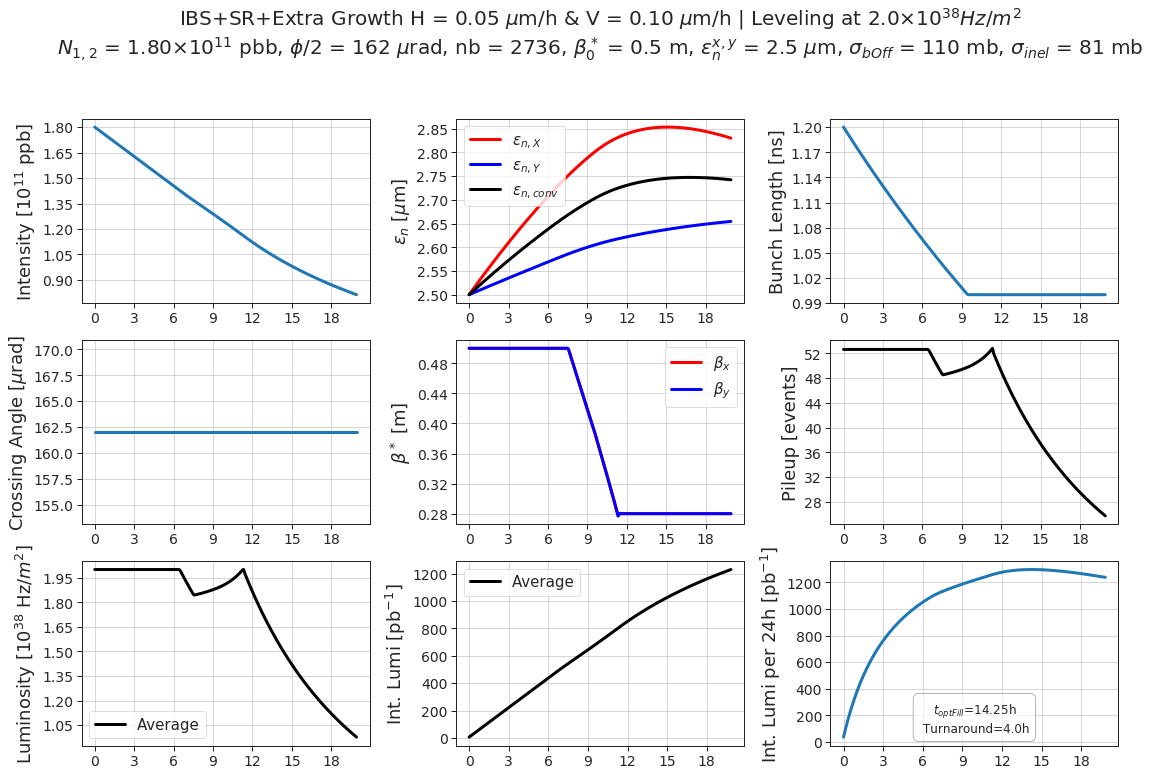

In [137]:
showExperiments = False

fig = plt.figure('evo', figsize=(18,12*1.3))
gsf = gridspec.GridSpec(4, 3)
gsf.update(left=0.1, right=0.9, wspace=0.3)
ax1 = plt.subplot(gsf[0,0])
ax2 = plt.subplot(gsf[0,1])
ax3 = plt.subplot(gsf[0,2])

ax4 = plt.subplot(gsf[1,0])
ax5 = plt.subplot(gsf[1,1])
ax6 = plt.subplot(gsf[1,2])

ax7 = plt.subplot(gsf[2,0])
ax8 = plt.subplot(gsf[2,1])
ax9 = plt.subplot(gsf[2,2])

# ax10 = plt.subplot(gsf[3,0])
# ax11 = plt.subplot(gsf[3,1])
# ax12 = plt.subplot(gsf[3,2])



# intensities
ax1.plot(np.array(sav_time)/3600., np.array(sav_npart)/1.0e11, lw=3)
ax1.set_xlabel("", fontsize=18)
ax1.set_ylabel("Intensity [$10^{11}$ ppb]", fontsize=18)
#ax1.set_ylim(0.5, 1.5)
ax1.grid('on')


# emittance
ax2.plot(np.array(sav_time)/3600., np.array(sav_emitn_x)*1.0e6,   'r-', lw=3, label='$\\varepsilon_{n,X}$')
ax2.plot(np.array(sav_time)/3600., np.array(sav_emitn_y)*1.0e6,   'b-', lw=3, label='$\\varepsilon_{n,Y}$')
ax2.plot(np.array(sav_time)/3600., np.array(sav_emitn_avg)*1.0e6, 'k-', lw=3, label='$\\varepsilon_{n,conv}$')
ax2.set_xlabel("", fontsize=18)
ax2.set_ylabel("$\epsilon_{n}$ [$\mu$m]", fontsize=18)
ax2.legend(loc='best', fontsize=15)
#ax7.set_ylim(2.2, 3.6)
ax2.grid('on')

# bunch length
ax3.plot(np.array(sav_time)/3600., np.array(sav_blength)*1.0e9, lw=3)
ax3.set_xlabel("", fontsize=18)
ax3.set_ylabel("Bunch Length [ns]", fontsize=18)
#ax3.set_ylim(0.5, 1.5)
ax3.grid('on')


# crossing
ax4.plot(np.array(sav_time)/3600., np.array(sav_xing)/1.0e-6, lw=3)
ax4.set_xlabel("", fontsize=18)
ax4.set_ylabel("Crossing Angle [$\mu$rad]", fontsize=18)
#ax4.set_ylim(120, 180)
ax4.grid('on')

# # beta*
# ax5.plot(np.array(sav_time)/3600., np.array(sav_bx_ATLAS), 'r-', lw=3, label="ATLAS $\\beta_{x}$")
# ax5.plot(np.array(sav_time)/3600., np.array(sav_by_ATLAS), 'b-', lw=3, label="ATLAS $\\beta_{y}$")
# ax5.plot(np.array(sav_time)/3600., np.array(sav_bx_CMS), 'r:', lw=3, label="CMS $\\beta_{x}$")
# ax5.plot(np.array(sav_time)/3600., np.array(sav_by_CMS), 'b:', lw=3, label="CMS $\\beta_{y}$")
# ax5.set_xlabel("", fontsize=18)
# ax5.set_ylabel("$\\beta^*$ [m]", fontsize=18)
# #ax5.set_ylim(0.1, 0.4)
# ax5.legend(loc='best', fontsize=15)
# ax5.grid('on')


ax5.plot(np.array(sav_time)/3600., np.array(sav_bx), 'r-', lw=3, label="$\\beta_{x}$")
ax5.plot(np.array(sav_time)/3600., np.array(sav_by), 'b-', lw=3, label="$\\beta_{y}$")
ax5.set_xlabel("", fontsize=18)
ax5.set_ylabel("$\\beta^*$ [m]", fontsize=18)
#ax5.set_ylim(0.1, 0.4)
ax5.legend(loc='best', fontsize=15)
ax5.grid('on')


# pileup
if showExperiments:
    ax6.plot(np.array(sav_time)/3600., np.array(sav_pileupATLAS), 'r-', lw=3, label='ATLAS')
    ax6.plot(np.array(sav_time)/3600., np.array(sav_pileupCMS),   'b-', lw=3, label='CMS')
ax6.plot(np.array(sav_time)/3600., np.array(sav_pileupAvg),   'k-', lw=3, label='Average')
ax6.set_xlabel("", fontsize=18)
ax6.set_ylabel("Pileup [events]", fontsize=18)
#ax6.set_ylim(10, 100)
ax6.grid('on')


# luminosity
if showExperiments:
    ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiATLAS)/1.0e38, 'r-', lw=3, label='ATLAS')
    ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiCMS)/1.0e38,   'b-', lw=3, label='CMS')
ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiAvg)/1.0e38,   'k-', lw=3, label='Average')
ax7.set_xlabel("", fontsize=18)
ax7.set_ylabel("Luminosity [$10^{38}$ Hz/$m^2$]", fontsize=18)
#ax7.set_ylim(0, 2.5)
ax7.legend(loc='best', fontsize=15)
ax7.grid('on')


# integrated lumi
if showExperiments:
    ax8.plot(np.array(sav_time[:-1])/3600., cumtrapz(sav_instLumiATLAS, x=sav_time)*1.0e-40, 'r-',   lw=3, label='ATLAS')
    ax8.plot(np.array(sav_time[:-1])/3600., cumtrapz(sav_instLumiCMS,   x=sav_time)*1.0e-40, 'b-',   lw=3, label='CMS')
ax8.plot(np.array(sav_time[:-1])/3600., cumtrapz(sav_instLumiAvg,   x=sav_time)*1.0e-40, 'k-',   lw=3, label='Average')
ax8.set_xlabel("", fontsize=18)
ax8.set_ylabel("Int. Lumi [pb$^{-1}$]", fontsize=18)
#ax8.set_ylim(0, 1500)
ax8.legend(loc='best', fontsize=15)
ax8.grid('on')

# integrated lumi per day
ax9.plot(np.array(sav_time[:-1])/3600., luminosity_day_full_beam, lw=3)
# ax9.plot(np.array(sav_time[:-1])/3600., luminosity_week_full_beam*1.0e-3, lw=3)
ax9.set_xlabel("", fontsize=18)
ax9.set_ylabel("Int. Lumi per 24h [pb$^{-1}$]", fontsize=18)
# ax9.set_ylabel("Int. Lumi per week [fb$^{-1}$]", fontsize=18)
#ax9.set_ylim(0, 1500)
ax9.text(0.5, 0.25, "$t_{optFill}$="+"{:.2f}h\n Turnaround={}h".format(optFillLength_h, turnaround_h), horizontalalignment='center', verticalalignment='top', transform=ax9.transAxes, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.7), fontweight='normal', fontsize=12)
ax9.grid('on')



ax10.plot(np.array(sav_time)/3600., np.array(sav_lumt_X_ATLAS), 'r-', lw=3, label="ATLAS")
ax10.plot(np.array(sav_time)/3600., np.array(sav_lumt_X_CMS), 'b-', lw=3, label="CMS")
ax10.set_xlabel("Time [h]", fontsize=18)
ax10.set_ylabel("$\\sigma_{L,X}$ [$\mathrm{\mu}$m]", fontsize=18)
ax10.legend(loc='best', fontsize=15)
ax10.grid('on')


ax11.plot(np.array(sav_time)/3600., np.array(sav_lumt_P_ATLAS), 'r-', lw=3, label="ATLAS")
ax11.plot(np.array(sav_time)/3600., np.array(sav_lumt_P_CMS), 'b-', lw=3, label="CMS")
ax11.set_xlabel("Time [h]", fontsize=18)
ax11.set_ylabel("$\\sigma_{L,P}$ [$\mathrm{\mu}$m]", fontsize=18)
ax11.legend(loc='best', fontsize=15)
ax11.grid('on')

ax12.plot(np.array(sav_time)/3600., np.array(sav_lumz_ATLAS), 'r-', lw=3, label="ATLAS")
ax12.plot(np.array(sav_time)/3600., np.array(sav_lumz_CMS), 'b-', lw=3, label="CMS")
ax12.set_xlabel("Time [h]", fontsize=18)
ax12.set_ylabel("$\\sigma_{L,Z}$ [mm]", fontsize=18)
ax12.legend(loc='best', fontsize=15)
ax12.grid('on')


if emitBU == 'Model':
    fig.suptitle("Pure IBS+SR: "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
                 +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
                 +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)
elif emitBU == 'ExtraBlowup':
    fig.suptitle("IBS+SR+Extra Growth H = 0.05 $\mu$m/h & V = 0.10 $\mu$m/h | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
                 +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
                 +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)


# fig.suptitle("No Emittance Growth | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                   +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                   +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(2.5e-6/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)




# ticklabels
plt.setp(ax1.get_xticklabels(), fontsize=14);
plt.setp(ax1.get_yticklabels(), fontsize=14);

plt.setp(ax2.get_xticklabels(), fontsize=14);
plt.setp(ax2.get_yticklabels(), fontsize=14);

plt.setp(ax3.get_xticklabels(), fontsize=14);
plt.setp(ax3.get_yticklabels(), fontsize=14);

plt.setp(ax4.get_xticklabels(), fontsize=14);
plt.setp(ax4.get_yticklabels(), fontsize=14);

plt.setp(ax5.get_xticklabels(), fontsize=14);
plt.setp(ax5.get_yticklabels(), fontsize=14);

plt.setp(ax6.get_xticklabels(), fontsize=14);
plt.setp(ax6.get_yticklabels(), fontsize=14);

plt.setp(ax7.get_xticklabels(), fontsize=14);
plt.setp(ax7.get_yticklabels(), fontsize=14);

plt.setp(ax8.get_xticklabels(), fontsize=14);
plt.setp(ax8.get_yticklabels(), fontsize=14);

plt.setp(ax9.get_xticklabels(), fontsize=14);
plt.setp(ax9.get_yticklabels(), fontsize=14);

# plt.setp(ax10.get_xticklabels(), fontsize=14);
# plt.setp(ax10.get_yticklabels(), fontsize=14);

# plt.setp(ax11.get_xticklabels(), fontsize=14);
# plt.setp(ax11.get_yticklabels(), fontsize=14);

# plt.setp(ax12.get_xticklabels(), fontsize=14);
# plt.setp(ax12.get_yticklabels(), fontsize=14);



setAxisMaxLocator(ax1, 'both', 8)
setAxisMaxLocator(ax2, 'both', 8)
setAxisMaxLocator(ax3, 'both', 8)
setAxisMaxLocator(ax4, 'both', 8)
setAxisMaxLocator(ax5, 'both', 8)
setAxisMaxLocator(ax6, 'both', 8)
setAxisMaxLocator(ax7, 'both', 8)
setAxisMaxLocator(ax8, 'both', 8)
setAxisMaxLocator(ax9, 'both', 8)
setAxisMaxLocator(ax10, 'both', 8)
setAxisMaxLocator(ax11, 'both', 8)
setAxisMaxLocator(ax12, 'both', 8)


# 

# filename = "LCR3_Nb{:.1f}_emit{:.1f}_Lumi{:.1f}_{}".format(sav_npart[0]/1.0e11, sav_emitn_x[0]/1.0e-6, maxLumi/1.0e38, emitBU)
# # fig.savefig(filename+".png", dpi=300)


In [55]:
print 'ATLAS lumz rel [%] ' , 100.0*(sav_lumz_ATLAS[-1] - sav_lumz_ATLAS[0])/sav_lumz_ATLAS[0]
print 'CMS   lumz rel [%] ' , 100.0*(sav_lumz_CMS[-1] - sav_lumz_CMS[0])/sav_lumz_CMS[0]

ATLAS lumz rel [%]  -40.156910285486454
CMS   lumz rel [%]  -39.09181838545369


In [62]:
alice_I_P = lumz(10.0, sav_emitn_y[0], 7460.5, sav_blength[0], 2.0e-6*(200.+70.))
alice_F_P = lumz(10.0, sav_emitn_y[-1], 7460.5, sav_blength[-1], 2.0e-6*(200.+70.))

alice_I_N = lumz(10.0, sav_emitn_y[0],  7460.5, sav_blength[0],   2.0e-6*(200.-70.))
alice_F_N = lumz(10.0, sav_emitn_y[-1], 7460.5, sav_blength[-1], 2.0e-6*(200.-70.))

print ' positive : ', 100.*(alice_I_P-alice_F_P)/alice_I_P
print ' negative : ', 100.*(alice_I_N-alice_F_N)/alice_I_N

 positive :  14.392485841059662
 negative :  16.088548747019875


In [63]:
lhcb_I_P = lumz(3.0, sav_emitn_x[0], 7460.5, sav_blength[0], 2.0e-6*(250.+135.))
lhcb_F_P = lumz(3.0, sav_emitn_x[-1], 7460.5, sav_blength[-1], 2.0e-6*(250.+135.))

lhcb_I_N = lumz(3.0, sav_emitn_x[0],  7460.5, sav_blength[0],   2.0e-6*(250.-135.))
lhcb_F_N = lumz(3.0, sav_emitn_x[-1], 7460.5, sav_blength[-1], 2.0e-6*(250.-135.))

print ' positive : ', 100.*(lhcb_I_P-lhcb_F_P)/lhcb_I_P
print ' negative : ', 100.*(lhcb_I_N-lhcb_F_N)/lhcb_I_N

 positive :  6.176443468565855
 negative :  15.066348934484754


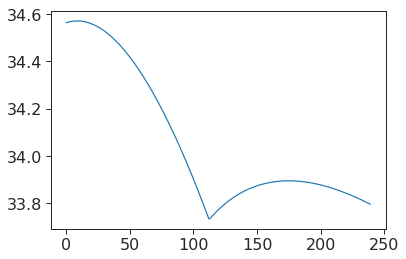

In [72]:
plt.plot(lumz(np.array([1.5]*len(sav_bx)), np.array(sav_emitn_x), 7460.5, np.array(sav_blength), np.array([2.0e-6*(250.0+135.0)]*len(sav_bx))) )

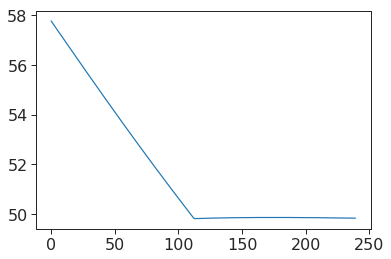

In [73]:
plt.plot(lumz(np.array([1.5]*len(sav_bx)), np.array(sav_emitn_x), 7460.5, np.array(sav_blength), np.array([2.0e-6*(250.0-135.0)]*len(sav_bx))) )

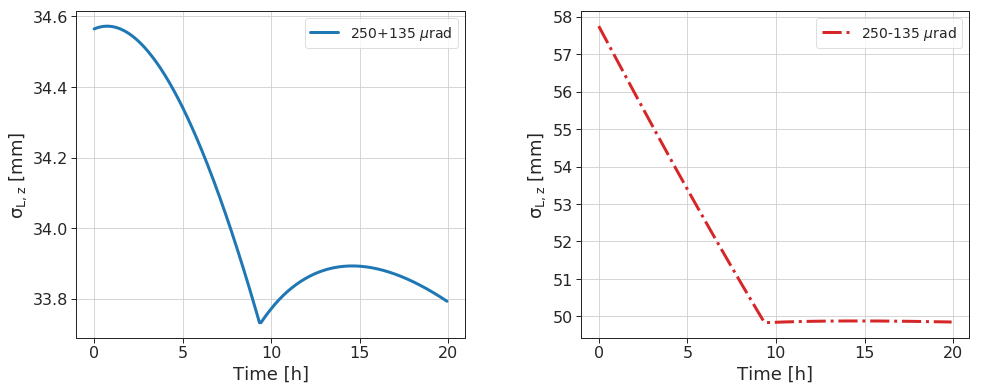

In [103]:
f = plt.figure('lhcb', figsize=(16,6))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(121) #plt.subplot(gs[0,0])
ax2 = plt.subplot(122) #plt.subplot(gs[0,1], sharex=ax1)

ax1.plot(np.array(sav_time)/3600., lumz(np.array([1.5]*len(sav_bx)), np.array(sav_emitn_x), 7460.5, np.array(sav_blength), np.array([2.0e-6*(250.0+135.0)]*len(sav_bx))) , 'C0-', lw=3, label='250+135 $\mu$rad')
ax2.plot(np.array(sav_time)/3600., lumz(np.array([1.5]*len(sav_bx)), np.array(sav_emitn_x), 7460.5, np.array(sav_blength), np.array([2.0e-6*(250.0-135.0)]*len(sav_bx))) , 'C3-.', lw=3, label='250-135 $\mu$rad')
ax1.grid('on')
ax2.grid('on')

ax1.legend(loc='upper right', fontsize=14, frameon=True, fancybox=True)
ax2.legend(loc='upper right', fontsize=14, frameon=True, fancybox=True)

ax1.set_xlabel("Time [h]")
ax2.set_xlabel("Time [h]")

ax1.set_ylabel("$\mathrm{\sigma_{L,z}}$ [mm]")
ax2.set_ylabel("$\mathrm{\sigma_{L,z}}$ [mm]")
f.subplots_adjust(wspace=0.3)

In [106]:
lumP = lumz(np.array([1.5]*len(sav_bx)), np.array(sav_emitn_x), 7460.5, np.array(sav_blength), np.array([2.0e-6*(250.0+135.0)]*len(sav_bx)))
lumN = lumz(np.array([1.5]*len(sav_bx)), np.array(sav_emitn_x), 7460.5, np.array(sav_blength), np.array([2.0e-6*(250.0-135.0)]*len(sav_bx)))

In [107]:
print 100.0*(lumP[-1]-lumP[0])/lumP[0]
print 100.0*(lumN[-1]-lumN[0])/lumN[0]

-2.2325783129518966
-13.675147079163326


In [18]:
m_25_xing        = np.array([200.0e-6+70.0e-6]*len(m_25_time)) #np.array(sav_xing)
m_25_xing_2      = np.array([200.0e-6-70.0e-6]*len(m_25_time)) #np.array(sav_xing)
m_25_emitGeo_x = np.array(sav_emitn_x)/gamma
m_25_emitGeo_y = np.array(sav_emitn_y)/gamma
m_25_bl        = np.array(sav_blength)
m_25_sigz      = np.array(sav_blength)*clight/4.0
m_25_bx        = np.array([10]*len(m_25_time)) #np.array(sav_bx)
m_25_by        = np.array([10]*len(m_25_time)) #np.array(sav_by)

In [19]:
m_25_sigma_x = np.sqrt(m_25_emitGeo_x*m_25_bx)
m_25_sigma_y = np.sqrt(m_25_emitGeo_y*m_25_by)

m_25_loss_x = 1/np.sqrt(1 + (m_25_sigz/m_25_sigma_x*m_25_xing)**2)
m_25_loss_y = 1/np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing)**2)

m_25_loss_x2 = 1/np.sqrt(1 + (m_25_sigz/m_25_sigma_x*m_25_xing_2)**2)
m_25_loss_y2 = 1/np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing_2)**2)

In [20]:
lumz_25_x     = m_25_sigma_x/np.sqrt(2.0)#*np.sqrt(1 + (m_25_sigz/m_25_sigma_x*m_25_xing)**2)
lumz_25_x_2   = m_25_sigma_x/np.sqrt(2.0)#*np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing_2)**2)

lumz_25_y       = m_25_sigma_y/np.sqrt(2.0)*np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing)**2)
lumz_25_y_2     = m_25_sigma_y/np.sqrt(2.0)*np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing_2)**2)
#---
lumz_s_25_x    = m_25_sigz/np.sqrt(2.0)*m_25_loss_x
lumz_s_25_x2    = m_25_sigz/np.sqrt(2.0)*m_25_loss_x2


lumz_s_25_y    = m_25_sigz/np.sqrt(2.0)*m_25_loss_y
lumz_s_25_y2   = m_25_sigz/np.sqrt(2.0)*m_25_loss_y2

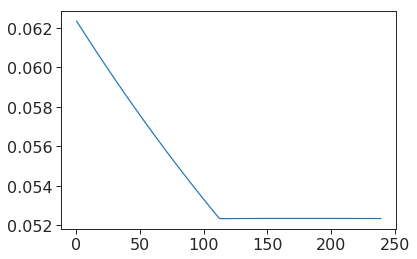

In [23]:
plt.plot(lumz_s_25_x2)

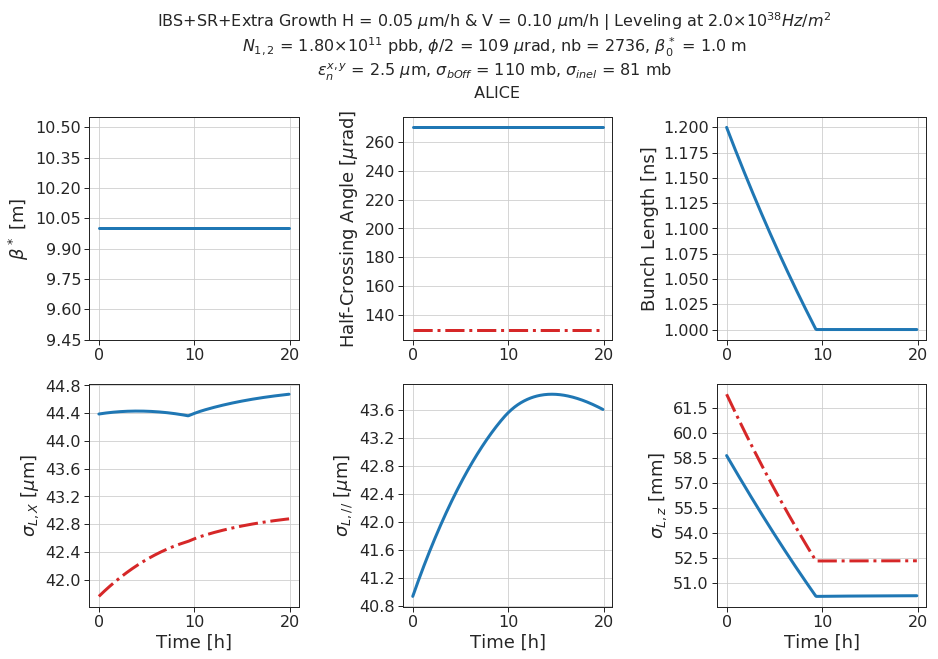

In [21]:
f = plt.figure('lumz', figsize=(15,9))
f.subplots_adjust(wspace=0.5)
gs = gridspec.GridSpec(2,3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharex=ax1)
ax3 = plt.subplot(gs[0,2], sharex=ax1)
ax4 = plt.subplot(gs[1,0], sharex=ax1)
ax5 = plt.subplot(gs[1,1], sharex=ax1)
ax6 = plt.subplot(gs[1,2], sharex=ax1)



ax1.plot(m_25_time, m_25_bx,   'C0-', lw=3)
ax2.plot(m_25_time, m_25_xing*1.0e6,   'C0-', lw=3, label="250+135$\mu$rad")
ax2.plot(m_25_time, m_25_xing_2*1.0e6,   'C3-.', lw=3, label="250-135$\mu$rad")
ax3.plot(m_25_time, m_25_bl*1.0e9,   'C0-', lw=3)

ax4.plot(m_25_time, lumz_25_y*1.0e6,   'C0-', lw=3, label="250+135$\mu$rad")
ax4.plot(m_25_time, lumz_25_y_2*1.0e6,   'C3-.', lw=3, label="250-135$\mu$rad")
ax5.plot(m_25_time, lumz_25_x*1.0e6,   'C0-', lw=3)
ax6.plot(m_25_time, lumz_s_25_y*1.0e3,    'C0-', lw=3,label="250+135$\mu$rad")
ax6.plot(m_25_time, lumz_s_25_y2*1.0e3,   'C3-.', lw=3,label="250-135$\mu$rad")


# ax2.plot(m_time, lumz_25_y*1.0e6,   'C0-', lw=3, label='$\sigma_{y}$ [$\mu$m]')
# ax3.plot(m_time, lumz_s_25_x*1.0e3, 'C0-', lw=3, label='$\sigma_{L,x}$ [mm]')
# ax4.plot(m_time, lumz_s_25_y*1.0e3, 'C0-', lw=3, label='$\sigma_{L,y}$ [mm]')

ax1.set_ylabel("$\\beta^*$ [m]")
ax2.set_ylabel("Half-Crossing Angle [$\mu$rad]")
ax3.set_ylabel("Bunch Length [ns]")
ax4.set_ylabel("$\sigma_{L,X}$ [$\mu$m]")
ax5.set_ylabel("$\sigma_{L,//}$ [$\mu$m]")
ax6.set_ylabel("$\sigma_{L,z}$ [mm]")


ax4.set_xlabel("Time [h]")
ax5.set_xlabel("Time [h]")
ax6.set_xlabel("Time [h]")



setAxisMaxLocator(ax1, 'y', 9)
setAxisMaxLocator(ax2, 'y', 9)
setAxisMaxLocator(ax3, 'y', 9)
setAxisMaxLocator(ax4, 'y', 9)
setAxisMaxLocator(ax5, 'y', 9)
setAxisMaxLocator(ax6, 'y', 9)



ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

f.suptitle("IBS+SR+Extra Growth H = 0.05 $\mu$m/h & V = 0.10 $\mu$m/h | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
                 +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
                 +"\n$\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb\n ALICE".format(sigma_inelastic_m2*1.0e31), y=1.05, fontsize=16);



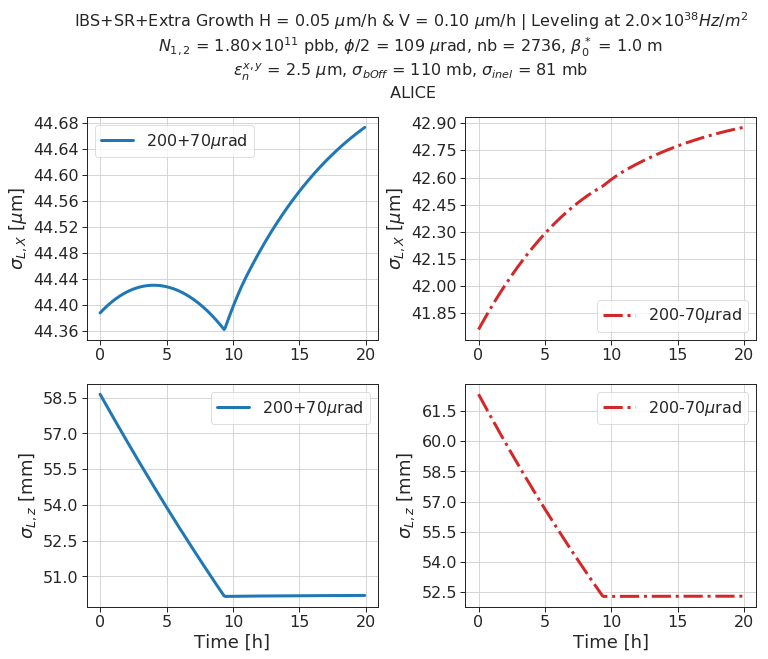

In [188]:
ff = plt.figure('lz', figsize=(12,9))
ff.subplots_adjust(wspace=0.3)
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1], sharex=ax1)
ax3 = plt.subplot(gs[1,0], sharex=ax1)
ax4 = plt.subplot(gs[1,1], sharex=ax1)

ax1.plot(m_25_time, lumz_25_y*1.0e6,   'C0-', lw=3,    label="200+70$\mu$rad")
ax2.plot(m_25_time, lumz_25_y_2*1.0e6,   'C3-.', lw=3, label="200-70$\mu$rad")
ax3.plot(m_25_time, lumz_s_25_y*1.0e3,    'C0-', lw=3, label="200+70$\mu$rad")
ax4.plot(m_25_time, lumz_s_25_y2*1.0e3,   'C3-.', lw=3,label="200-70$\mu$rad")

ax1.set_ylabel("$\sigma_{L,X}$ [$\mu$m]")
ax2.set_ylabel("$\sigma_{L,X}$ [$\mu$m]")

ax3.set_ylabel("$\sigma_{L,z}$ [mm]")
ax4.set_ylabel("$\sigma_{L,z}$ [mm]")

ax3.set_xlabel("Time [h]")
ax4.set_xlabel("Time [h]")



ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

setAxisMaxLocator(ax1, 'y', 9)
setAxisMaxLocator(ax2, 'y', 9)
setAxisMaxLocator(ax3, 'y', 9)
setAxisMaxLocator(ax4, 'y', 9)

ff.suptitle("IBS+SR+Extra Growth H = 0.05 $\mu$m/h & V = 0.10 $\mu$m/h | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
                 +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
                 +"\n$\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb\n ALICE".format(sigma_inelastic_m2*1.0e31), y=1.05, fontsize=16);



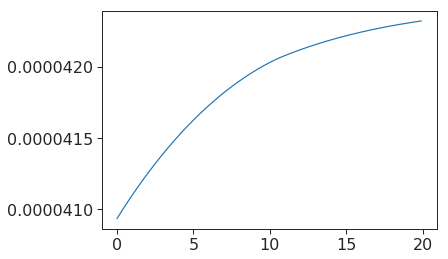

In [203]:
a = m_25_sigma_y/np.sqrt(2.0)*np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing)**2)
b = m_25_sigma_y/np.sqrt(2.0)*np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing_2)**2)
#plt.plot(m_25_sigma_y)
plt.plot(m_25_time, m_25_sigma_y/np.sqrt(2.0))

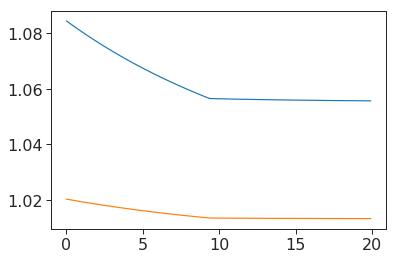

In [206]:
plt.plot(m_25_time, np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing)**2))
plt.plot(m_25_time, np.sqrt(1 + (m_25_sigz/m_25_sigma_y*m_25_xing_2)**2))

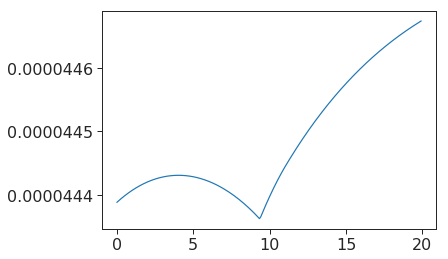

In [204]:
plt.plot(m_25_time, a)

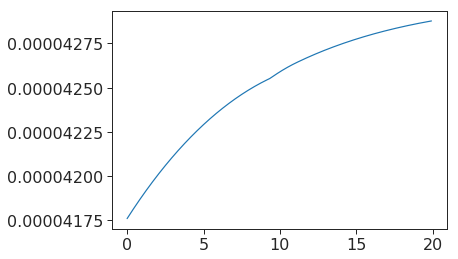

In [205]:
plt.plot(m_25_time, b)

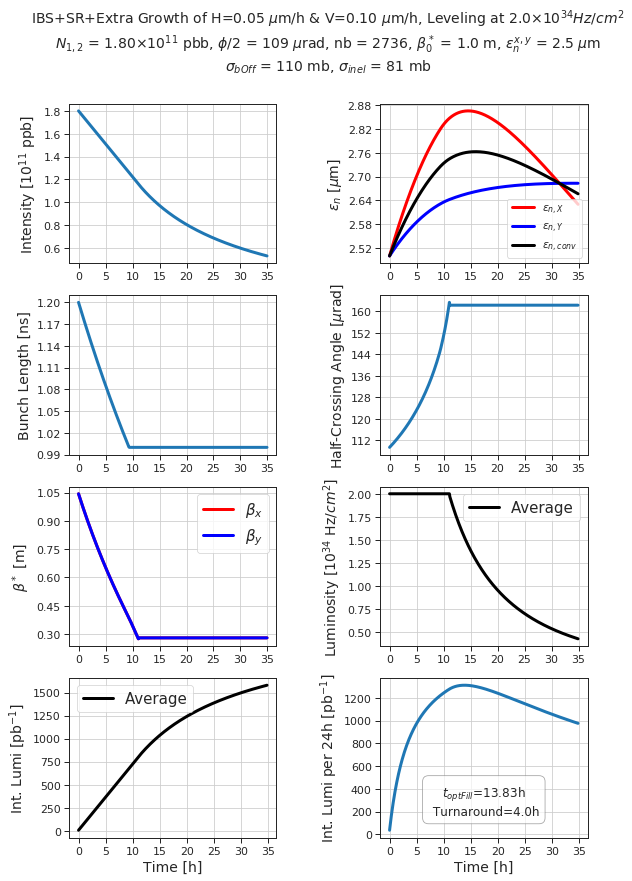

In [18]:
showExperiments = False

fig = plt.figure('evo', figsize=(6*1.5,9*1.5))
gsf = gridspec.GridSpec(4, 2)
gsf.update(left=0.1, right=0.9, wspace=0.5)
ax1 = plt.subplot(gsf[0,0])
ax2 = plt.subplot(gsf[0,1])

ax3 = plt.subplot(gsf[1,0])
ax4 = plt.subplot(gsf[1,1])

ax5 = plt.subplot(gsf[2,0])
ax7 = plt.subplot(gsf[2,1])

ax8 = plt.subplot(gsf[3,0])
ax9 = plt.subplot(gsf[3,1])


# intensities
ax1.plot(np.array(sav_time)/3600., np.array(sav_npart)/1.0e11, lw=3)
ax1.set_xlabel("", fontsize=18)
ax1.set_ylabel("Intensity [$10^{11}$ ppb]", fontsize=14)
#ax1.set_ylim(0.5, 1.5)
ax1.grid('on')


# emittance
ax2.plot(np.array(sav_time)/3600., np.array(sav_emitn_x)*1.0e6,   'r-', lw=3, label='$\\varepsilon_{n,X}$')
ax2.plot(np.array(sav_time)/3600., np.array(sav_emitn_y)*1.0e6,   'b-', lw=3, label='$\\varepsilon_{n,Y}$')
ax2.plot(np.array(sav_time)/3600., np.array(sav_emitn_avg)*1.0e6, 'k-', lw=3, label='$\\varepsilon_{n,conv}$')
ax2.set_xlabel("", fontsize=18)
ax2.set_ylabel("$\epsilon_{n}$ [$\mu$m]", fontsize=14)
ax2.legend(loc='best', fontsize=11)
#ax7.set_ylim(2.2, 3.6)
ax2.grid('on')

# bunch length
ax3.plot(np.array(sav_time)/3600., np.array(sav_blength)*1.0e9, lw=3)
ax3.set_xlabel("", fontsize=18)
ax3.set_ylabel("Bunch Length [ns]", fontsize=14)
#ax3.set_ylim(0.5, 1.5)
ax3.grid('on')


# crossing
ax4.plot(np.array(sav_time)/3600., np.array(sav_xing)/1.0e-6, lw=3)
ax4.set_xlabel("", fontsize=18)
ax4.set_ylabel("Half-Crossing Angle [$\mu$rad]", fontsize=14)
#ax4.set_ylim(120, 180)
ax4.grid('on')

# # beta*
# ax5.plot(np.array(sav_time)/3600., np.array(sav_bx_ATLAS), 'r-', lw=3, label="ATLAS $\\beta_{x}$")
# ax5.plot(np.array(sav_time)/3600., np.array(sav_by_ATLAS), 'b-', lw=3, label="ATLAS $\\beta_{y}$")
# ax5.plot(np.array(sav_time)/3600., np.array(sav_bx_CMS), 'r:', lw=3, label="CMS $\\beta_{x}$")
# ax5.plot(np.array(sav_time)/3600., np.array(sav_by_CMS), 'b:', lw=3, label="CMS $\\beta_{y}$")
# ax5.set_xlabel("", fontsize=18)
# ax5.set_ylabel("$\\beta^*$ [m]", fontsize=18)
# #ax5.set_ylim(0.1, 0.4)
# ax5.legend(loc='best', fontsize=15)
# ax5.grid('on')


ax5.plot(np.array(sav_time)/3600., np.array(sav_bx), 'r-', lw=3, label="$\\beta_{x}$")
ax5.plot(np.array(sav_time)/3600., np.array(sav_by), 'b-', lw=3, label="$\\beta_{y}$")
ax5.set_xlabel("", fontsize=18)
ax5.set_ylabel("$\\beta^*$ [m]", fontsize=14)
#ax5.set_ylim(0.1, 0.4)
ax5.legend(loc='best', fontsize=15)
ax5.grid('on')


# # pileup
# if showExperiments:
#     ax6.plot(np.array(sav_time)/3600., np.array(sav_pileupATLAS), 'r-', lw=3, label='ATLAS')
#     ax6.plot(np.array(sav_time)/3600., np.array(sav_pileupCMS),   'b-', lw=3, label='CMS')
# ax6.plot(np.array(sav_time)/3600., np.array(sav_pileupAvg),   'k-', lw=3, label='Average')
# ax6.set_xlabel("", fontsize=18)
# ax6.set_ylabel("Pileup [events]", fontsize=18)
# #ax6.set_ylim(10, 100)
# ax6.grid('on')


# luminosity
if showExperiments:
    ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiATLAS)/1.0e38, 'r-', lw=3, label='ATLAS')
    ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiCMS)/1.0e38,   'b-', lw=3, label='CMS')
ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiAvg)/1.0e38,   'k-', lw=3, label='Average')
# ax7.set_xlabel("Time [h]", fontsize=18)
ax7.set_ylabel("Luminosity [$10^{34}$ Hz/$cm^2$]", fontsize=14)
#ax7.set_ylim(0, 2.5)
ax7.legend(loc='best', fontsize=15)
ax7.grid('on')


# integrated lumi
if showExperiments:
    ax8.plot(np.array(sav_time[:-1])/3600., cumtrapz(sav_instLumiATLAS, x=sav_time)*1.0e-40, 'r-',   lw=3, label='ATLAS')
    ax8.plot(np.array(sav_time[:-1])/3600., cumtrapz(sav_instLumiCMS,   x=sav_time)*1.0e-40, 'b-',   lw=3, label='CMS')
ax8.plot(np.array(sav_time[:-1])/3600., cumtrapz(sav_instLumiAvg,   x=sav_time)*1.0e-40, 'k-',   lw=3, label='Average')
ax8.set_xlabel("Time [h]", fontsize=14)
ax8.set_ylabel("Int. Lumi [pb$^{-1}$]", fontsize=14)
#ax8.set_ylim(0, 1500)
ax8.legend(loc='best', fontsize=15)
ax8.grid('on')

# integrated lumi per day
ax9.plot(np.array(sav_time[:-1])/3600., luminosity_day_full_beam, lw=3)
# ax9.plot(np.array(sav_time[:-1])/3600., luminosity_week_full_beam*1.0e-3, lw=3)
ax9.set_xlabel("Time [h]", fontsize=14)
ax9.set_ylabel("Int. Lumi per 24h [pb$^{-1}$]", fontsize=14)
# ax9.set_ylabel("Int. Lumi per week [fb$^{-1}$]", fontsize=18)
#ax9.set_ylim(0, 1500)
ax9.text(0.5, 0.35, "$t_{optFill}$="+"{:.2f}h\n Turnaround={}h".format(optFillLength_h, turnaround_h), horizontalalignment='center', verticalalignment='top', transform=ax9.transAxes, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.7), fontweight='normal', fontsize=12)
ax9.grid('on')



# if emitBU == 'Model':
#     fig.suptitle("Pure IBS+SR: "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                  +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                  +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)
# elif emitBU == 'ExtraBlowup':
#     fig.suptitle("IBS+SR+Extra Growth H = 0.05 $\mu$m/h & V = 0.10 $\mu$m/h | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                  +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                  +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)


# fig.suptitle("No Emittance Growth | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                   +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                   +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(2.5e-6/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)


fig.suptitle("IBS+SR+Extra Growth of H=0.05 $\mu$m/h & V=0.10 $\mu$m/h, "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{34} Hz/cm^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
                 +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}, ".format(nb)+"$\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
                 +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m\n$\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=14)





# ticklabels
plt.setp(ax1.get_xticklabels(), fontsize=11);
plt.setp(ax1.get_yticklabels(), fontsize=11);

plt.setp(ax2.get_xticklabels(), fontsize=11);
plt.setp(ax2.get_yticklabels(), fontsize=11);

plt.setp(ax3.get_xticklabels(), fontsize=11);
plt.setp(ax3.get_yticklabels(), fontsize=11);

plt.setp(ax4.get_xticklabels(), fontsize=11);
plt.setp(ax4.get_yticklabels(), fontsize=11);

plt.setp(ax5.get_xticklabels(), fontsize=11);
plt.setp(ax5.get_yticklabels(), fontsize=11);

plt.setp(ax6.get_xticklabels(), fontsize=11);
plt.setp(ax6.get_yticklabels(), fontsize=11);

plt.setp(ax7.get_xticklabels(), fontsize=11);
plt.setp(ax7.get_yticklabels(), fontsize=11);

plt.setp(ax8.get_xticklabels(), fontsize=11);
plt.setp(ax8.get_yticklabels(), fontsize=11);

plt.setp(ax9.get_xticklabels(), fontsize=11);
plt.setp(ax9.get_yticklabels(), fontsize=11);

setAxisMaxLocator(ax1, 'both', 8)
setAxisMaxLocator(ax2, 'both', 8)
setAxisMaxLocator(ax3, 'both', 8)
setAxisMaxLocator(ax4, 'both', 8)
setAxisMaxLocator(ax5, 'both', 8)
setAxisMaxLocator(ax6, 'both', 8)
setAxisMaxLocator(ax7, 'both', 8)
setAxisMaxLocator(ax8, 'both', 8)
setAxisMaxLocator(ax9, 'both', 8)


# 

# filename = "LCR3_Nb{:.1f}_emit{:.1f}_Lumi{:.1f}_{}".format(sav_npart[0]/1.0e11, sav_emitn_x[0]/1.0e-6, maxLumi/1.0e38, emitBU)
# # fig.savefig(filename+".png", dpi=300)



In [19]:
mtime = np.array(sav_time)[:-1]/3600.
mxing_25_2736 = np.array(sav_xing)[:-1]*1.0e6
mintLumi_25_2736 = np.array(integr_LumiAvg_pb)/1000.
minstLumi_25_2736 = np.array(sav_instLumiAvg)[:-1]*1.0e-38
minstLumiPerc_25_2736 = np.array(integr_LumiAvg_pb)/np.array(integr_LumiAvg_pb)[np.argmax(luminosity_day_full_beam)]*100.
mbx_25_2736 = np.array(sav_bx)[:-1]

In [20]:
mtime = np.array(sav_time)[:-1]/3600.
mxing_18_2736 = np.array(sav_xing)[:-1]*1.0e6
mintLumi_18_2736 = np.array(integr_LumiAvg_pb)/1000.
minstLumi_18_2736 = np.array(sav_instLumiAvg)[:-1]*1.0e-38
minstLumiPerc_18_2736 = np.array(integr_LumiAvg_pb)/np.array(integr_LumiAvg_pb)[np.argmax(luminosity_day_full_beam)]*100.
mbx_18_2736 = np.array(sav_bx)[:-1]

In [21]:
mxing_18_2484 = np.array(sav_xing)[:-1]*1.0e6
mintLumi_18_2484 = np.array(integr_LumiAvg_pb)/1000.
minstLumi_18_2484 = np.array(sav_instLumiAvg)[:-1]*1.0e-38
minstLumiPerc_18_2484 = np.array(integr_LumiAvg_pb)/np.array(integr_LumiAvg_pb)[np.argmax(luminosity_day_full_beam)]*100.
mbx_18_2484 = np.array(sav_bx)[:-1]

In [22]:
mxing_25_2484 = np.array(sav_xing)[:-1]*1.0e6
mintLumi_25_2484 = np.array(integr_LumiAvg_pb)/1000.
minstLumi_25_2484 = np.array(sav_instLumiAvg)[:-1]*1.0e-38
minstLumiPerc_25_2484 = np.array(integr_LumiAvg_pb)/np.array(integr_LumiAvg_pb)[np.argmax(luminosity_day_full_beam)]*100.
mbx_25_2484 = np.array(sav_bx)[:-1]

In [23]:
luminosity(gamma=gamma, bx_m=1.09, by_m=1.09, enx_m=2.5e-6, eny_m=2.5e-6, Npart_ppb=1e11, nb=nb, frev_hz=frev, blength_s=1.2e-9, phi_rad=2.0e-6*110, experiment='ATLAS', crab=False)/1.0e38

0.5932921866561652

In [24]:
(1.0e-9*clight/4.0)/np.sqrt(2)/np.sqrt(1+ (((1.0e-9*clight/4.0)/np.sqrt(2.5e-6/gamma*0.28)) * 160e-6)**2)*100

3.330130883180238

1.0437645399184514
1.0437645399184514
1.0437645399184514
1.0437645399184514


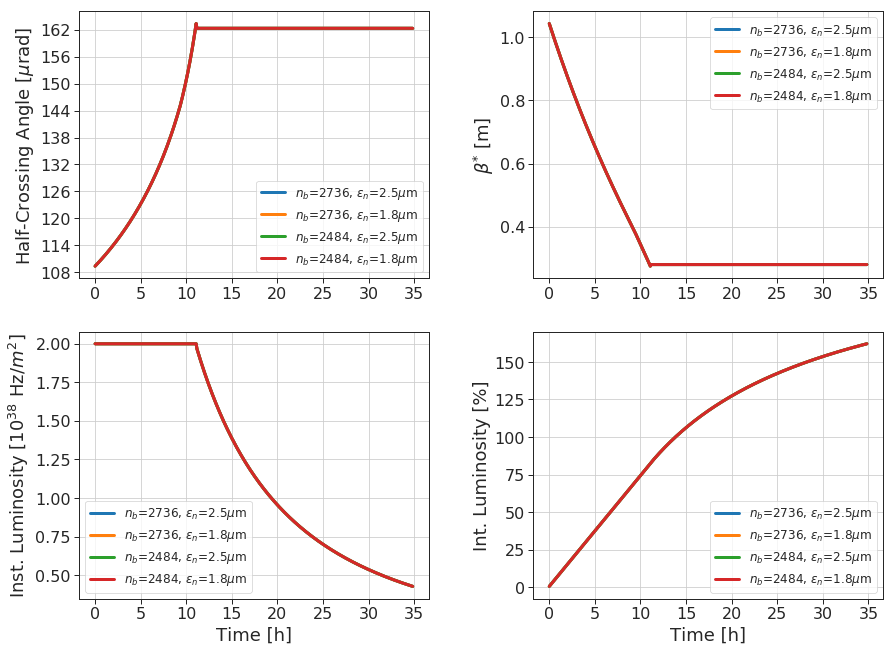

In [25]:
f1  = plt.figure('afig', figsize=(12*1.2,9*1.2))
f1.subplots_adjust(wspace=0.3)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, sharex=ax1)
ax3 = plt.subplot(223, sharex=ax1)
ax4 = plt.subplot(224, sharex=ax1)

ax1.plot(mtime, mxing_25_2736, 'C0-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m')
ax1.plot(mtime, mxing_18_2736, 'C1-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m')
ax1.plot(mtime, mxing_25_2484, 'C2-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m')
ax1.plot(mtime, mxing_18_2484, 'C3-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m')
ax1.grid('on')
ax1.set_ylabel("Half-Crossing Angle [$\mu$rad]")
ax1.legend(loc='lower right', frameon=True, fancybox=True, fontsize=12)



ax2.plot(mtime, mbx_25_2736, 'C0-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m')
ax2.plot(mtime, mbx_18_2736, 'C1-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m')
ax2.plot(mtime, mbx_25_2484, 'C2-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m')
ax2.plot(mtime, mbx_18_2484, 'C3-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m')
ax2.grid('on')
ax2.set_ylabel("$\\beta^{*}$ [m]")
ax2.legend(loc='upper right', frameon=True, fancybox=True, fontsize=12)

ax3.plot(mtime, minstLumi_25_2736, 'C0-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m')
ax3.plot(mtime, minstLumi_18_2736, 'C1-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m')
ax3.plot(mtime, minstLumi_25_2484, 'C2-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m')
ax3.plot(mtime, minstLumi_18_2484, 'C3-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m')
ax3.grid('on')
ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Inst. Luminosity [$10^{38}$ Hz/$m^2$]")
ax3.legend(loc='lower left', frameon=True, fancybox=True, fontsize=12)

ax4.plot(mtime, minstLumiPerc_25_2736, 'C0-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m')
ax4.plot(mtime, minstLumiPerc_18_2736, 'C1-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m')
ax4.plot(mtime, minstLumiPerc_25_2484, 'C2-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m')
ax4.plot(mtime, minstLumiPerc_18_2484, 'C3-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m')
ax4.grid('on')
ax4.set_ylabel("Int. Luminosity [%]")
ax4.set_xlabel("Time [h]")
ax4.legend(loc='lower right', frameon=True, fancybox=True, fontsize=12)



setAxisMaxLocator(ax1, 'x', 8)
setAxisMaxLocator(ax1, 'y', 10)

# ax1.plot(f4, f1, "r-o", lw=3, label="Normalized to the fill integrated luminosity at the optimal fill length")
# #ax1.plot(f3, f1, "b", lw=3, label="Normalized to the maximum integrated luminosity per 24h ($t_{turnaround}$=4h)")
# ax1.set_xlabel("Percentage [%]")
# ax1.set_ylabel("Half Crossing Angle [$\mu$rad]")
# setAxisMaxLocator(ax1, 'x', 13)
# setAxisMaxLocator(ax1, 'y', 12)
# ax1.set_title("Percentage of Integrated Luminosity per fill", fontsize=20)
# ax1.grid('on')
# ax1.legend(loc='lower right', fontsize=14)

print mbx_25_2736[0]
print mbx_18_2736[0]
print mbx_25_2484[0]
print mbx_18_2484[0]

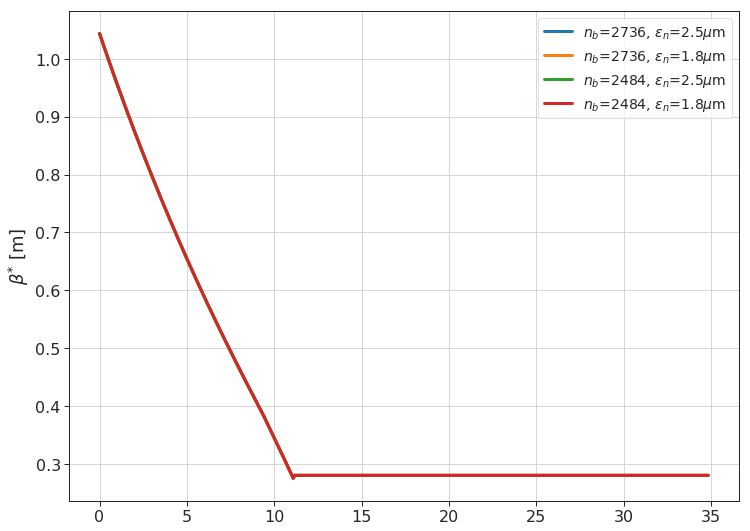

In [26]:
f = plt.figure('b', figsize=(12,9))
ax2 = plt.subplot()
ax2.plot(mtime, mbx_25_2736, 'C0-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m')
ax2.plot(mtime, mbx_18_2736, 'C1-', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m')
ax2.plot(mtime, mbx_25_2484, 'C2-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m')
ax2.plot(mtime, mbx_18_2484, 'C3-', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m')
ax2.grid('on')
ax2.set_ylabel("$\\beta^{*}$ [m]")
ax2.legend(loc='upper right', frameon=True, fancybox=True, fontsize=14)




In [27]:
# f0 = np.array(sav_time)[:-1]/3600.
# f1 = np.array(sav_xing)[:-1]*1.0e6
# f2 = np.array(sav_instLumiAvg)[:-1]*1.0e-38
# f3 = np.array(integr_LumiAvg_pb)/luminosity_day_full_max*100.
# f4 = np.array(integr_LumiAvg_pb)/np.array(integr_LumiAvg_pb)[np.argmax(luminosity_day_full_beam)]*100.
# f5 = np.array(sav_bx)[:-1]
# f6 = np.array(sav_emitn_x)[:-1]*1.0e6
# f7 = np.array(sav_emitn_y)[:-1]*1.0e6
# f8 = np.array(sav_emitn_avg)[:-1]*1.0e6
# f9 = np.array(sav_blength)[:-1]*1.0e9

NameError: name 'f4' is not defined

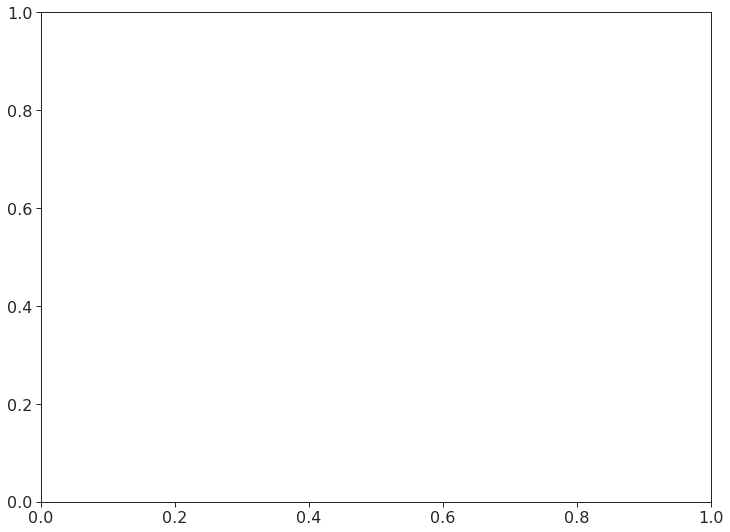

In [28]:
ff1  = plt.figure('lastplot2', figsize=(12,9))
ax1 = plt.subplot(111)
ax1.plot(f4, f1, "r-o", lw=3, label="Normalized to the fill integrated luminosity at the optimal fill length")
#ax1.plot(f3, f1, "b", lw=3, label="Normalized to the maximum integrated luminosity per 24h ($t_{turnaround}$=4h)")
ax1.set_xlabel("Percentage [%]")
ax1.set_ylabel("Half Crossing Angle [$\mu$rad]")
setAxisMaxLocator(ax1, 'x', 13)
setAxisMaxLocator(ax1, 'y', 12)
ax1.set_title("Percentage of Integrated Luminosity per fill", fontsize=20)
ax1.grid('on')
ax1.legend(loc='lower right', fontsize=14)

In [ ]:
ff1  = plt.figure('lastplot2', figsize=(12,9))
ax1 = plt.subplot(111)
ax1.plot(f4, f1, "r-o", lw=3, label="Normalized to the fill integrated\nluminosity at the optimal fill length")

ax2 = ax1.twinx()
ax2.plot(f4, f5, "b-o", lw=3)

#ax1.plot(f3, f1, "b", lw=3, label="Normalized to the maximum integrated luminosity per 24h ($t_{turnaround}$=4h)")
ax1.set_xlabel("Percentage [%]")
ax1.set_ylabel("Half Crossing Angle [$\mu$rad]")
ax2.set_ylabel("$\\beta^{*}$ [m]")
setAxisMaxLocator(ax1, 'x', 13)
setAxisMaxLocator(ax1, 'y', 12)
ax1.set_title("Percentage of Integrated Luminosity per fill", fontsize=20)
ax1.grid('on')
ax1.legend(loc='center right', fontsize=14)

In [ ]:
%matplotlib inline
ff1  = plt.figure('lastplot2', figsize=(12,9))
ax1 = plt.subplot(111)
ax1.plot(minstLumiPerc_25_2736, mxing_25_2736, "C0-", lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m')
ax1.plot(minstLumiPerc_18_2736, mxing_18_2736, "C1-", lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m')
ax1.plot(minstLumiPerc_25_2484, mxing_25_2484, "C2-", lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m')
ax1.plot(minstLumiPerc_18_2484, mxing_18_2484, "C3-", lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m')


ax2 = ax1.twinx()
ax2.plot(minstLumiPerc_25_2736, mbx_25_2736, "C0:", lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m')
ax2.plot(minstLumiPerc_18_2736, mbx_18_2736, "C1:", lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m')
ax2.plot(minstLumiPerc_25_2484, mbx_25_2484, "C2:", lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m')
ax2.plot(minstLumiPerc_18_2484, mbx_18_2484, "C3:", lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m')

ax1.set_xlim(0, 100)
setAxisMaxLocator(ax1, 'x', 11)
setAxisMaxLocator(ax1, 'y', 14)
ax1.grid('on')
ax2.axhline(0.5, color='k',ls='-', lw=3)

setAxisMaxLocator(ax2, 'y', 15)
ax1.set_xlabel("Luminosity Percentage [%]")
ax1.set_ylabel("Half Crossing Angle [$\mu$rad]")
ax2.set_ylabel("$\\beta^{*}$ [m]")
ax1.set_title("Percentage of Integrated Luminosity per fill", fontsize=20)
ax1.legend(loc='center right', fontsize=14)

In [ ]:
print '2.5 | 2736', minstLumiPerc_25_2736[mbx_25_2736>0.50][-1]
print '1.8 | 2736', minstLumiPerc_18_2736[mbx_18_2736>0.50][-1]
print '2.5 | 2484', minstLumiPerc_25_2484[mbx_25_2484>0.50][-1]
print '1.8 | 2484', minstLumiPerc_18_2484[mbx_18_2484>0.50][-1]

In [ ]:
(minstLumiPerc_25_2736[mbx_25_2736>0.50][-1] + minstLumiPerc_18_2736[mbx_18_2736>0.50][-1] + minstLumiPerc_25_2484[mbx_25_2484>0.50][-1] + minstLumiPerc_18_2484[mbx_18_2484>0.50][-1])/4.0

####f f1

In [ ]:
#f1*np.diff(f4)
24./17.*np.sum(f1[1:]*np.diff(f3))/100.

In [32]:
f3 = np.array(integr_LumiAvg_pb)/luminosity_day_full_max*100.
f1 = np.array(sav_xing)[:-1]*1.0e6
np.sum(f1[1:]*np.diff(f3))/100.

131.60143400578448

In [ ]:
print '2.5 | 2736',np.sum(mxing_25_2736[minstLumiPerc_25_2736<=100][1:]*np.diff(minstLumiPerc_25_2736[minstLumiPerc_25_2736<=100])/100)
print '1.8 | 2736',np.sum(mxing_18_2736[minstLumiPerc_18_2736<=100][1:]*np.diff(minstLumiPerc_18_2736[minstLumiPerc_18_2736<=100])/100)
print '2.5 | 2484',np.sum(mxing_25_2484[minstLumiPerc_25_2484<=100][1:]*np.diff(minstLumiPerc_25_2484[minstLumiPerc_25_2484<=100])/100)
print '1.8 | 2484',np.sum(mxing_18_2484[minstLumiPerc_18_2484<=100][1:]*np.diff(minstLumiPerc_18_2484[minstLumiPerc_18_2484<=100])/100)

In [ ]:
ff  = plt.figure('lastplot', figsize=(12,9))
ax1 = plt.subplot(111)
ax1.plot(f3, f1, "C1-o", lw=3)
ax1.set_xlabel("Int. Fill Luminosity / Optimal Luminosity Per 24h [%]")
ax1.set_ylabel("Half Crossing Angle [$\mu$rad]")
setAxisMaxLocator(ax1, 'x', 11)
setAxisMaxLocator(ax1, 'y', 12)
plt.grid('on')

In [ ]:
df = pd.DataFrame()

In [ ]:
df['time']        = f0.tolist()
df['xing']        = f1.tolist()
df['instLumi']    = f2.tolist()
df['fracOptimal'] = f3.tolist()
df['fracOptimal_2'] = f4.tolist()
df['betastar']    = f5.tolist()
df['enx']         = f6.tolist()
df['eny']         = f7.tolist()
df['enavg']       = f8.tolist()
df['bl']          = f9.tolist()

In [ ]:
np.savetxt(r'francesco_new.txt', df.values, fmt='%.3f')

In [ ]:
! head francesco_new.txt

In [ ]:
f = plt.figure(124, figsize=(12, 9))
ax1 = plt.subplot(111)
ax1.plot(f5, f4, 'C0-', lw=3)
setAxisMaxLocator(ax1, 'y', 11)
ax1.grid('on')
ax1.set_xlabel("$\\beta^{*}$ [m]")
ax1.set_ylabel("Integrated Luminosity per 24h Normalized to Max [%]")

In [ ]:
np.array(integr_LumiAvg_pb)[np.argmax(luminosity_day_full_beam)]

# Read JSON to Pandas

In [ ]:
df = pd.read_table("lpc.dat", header=None)

In [ ]:
df.columns = ['Fill', 'Start', 'SB', 'Type', 'Inj', 'end','ta', 'fl']

In [ ]:
df = df.reindex(index=df.index[::-1])

In [ ]:
ndf = df[df['fl']==False]

In [ ]:
ndf['dur_sec'] = ndf['SB'].apply(lambda x: np.float(x.split(":")[0])*3600+np.float(x.split(":")[1])*60+np.float(x.split(":")[2]))/3600.

In [ ]:
ndf['date'] = pd.to_datetime(df['Start'])

In [ ]:
ndf

In [ ]:
fillnums = ndf['Fill'].values

In [ ]:
t_hour = ndf['dur_sec'].values

In [ ]:
t_date = ndf['Start'].values

In [ ]:
np.mean(t_hour)

In [ ]:
def findclosest(ftime, value):
    return np.argmin(np.abs(ftime-value))

In [ ]:
my_int_lumi_25_2736 = []
my_int_lumi_25_2484 = []
my_int_lumi_18_2736 = []
my_int_lumi_18_2484 = []

my_bstar_25_2736 = []
my_bstar_25_2484 = []
my_bstar_18_2736 = []
my_bstar_18_2484 = []


my_xing_25_2736 = []
my_xing_25_2484 = []
my_xing_18_2736 = []
my_xing_18_2484 = []


my_xingW_25_2736 = []
my_xingW_25_2484 = []
my_xingW_18_2736 = []
my_xingW_18_2484 = []

for val in t_hour:
    mindx = findclosest(np.array(sav_time)/3600., val)
    my_int_lumi_25_2736.append(mintLumi_25_2736[mindx])
    my_int_lumi_25_2484.append(mintLumi_25_2484[mindx])
    my_int_lumi_18_2736.append(mintLumi_18_2736[mindx])
    my_int_lumi_18_2484.append(mintLumi_18_2484[mindx])
    
    my_bstar_25_2736.append(mbx_25_2736[mindx])
    my_bstar_25_2484.append(mbx_25_2484[mindx])
    my_bstar_18_2736.append(mbx_18_2736[mindx])
    my_bstar_18_2484.append(mbx_18_2484[mindx])
    
    
    my_xing_25_2736.append(np.nanmean(mxing_25_2736[:mindx]))
    my_xing_25_2484.append(np.nanmean(mxing_25_2484[:mindx]))
    my_xing_18_2736.append(np.nanmean(mxing_18_2736[:mindx]))
    my_xing_18_2484.append(np.nanmean(mxing_18_2484[:mindx]))
    

    
my_int_lumi_25_2736 = np.array(my_int_lumi_25_2736)
my_int_lumi_25_2484 = np.array(my_int_lumi_25_2484)
my_int_lumi_18_2736 = np.array(my_int_lumi_18_2736)
my_int_lumi_18_2484 = np.array(my_int_lumi_18_2484)

my_bstar_25_2736 = np.array(my_bstar_25_2736)
my_bstar_25_2484 = np.array(my_bstar_25_2484)
my_bstar_18_2736 = np.array(my_bstar_18_2736)
my_bstar_18_2484 = np.array(my_bstar_18_2484)


my_xing_25_2736 = np.array(my_xing_25_2736)
my_xing_25_2484 = np.array(my_xing_25_2484)
my_xing_18_2736 = np.array(my_xing_18_2736)
my_xing_18_2484 = np.array(my_xing_18_2484)

In [ ]:
plt.plot(mintLumi_18_2736)
#np.cumsum(my_int_lumi_25_2736)
# np.cumsum(my_int_lumi_18_2736)

In [ ]:
#plt.plot(fillnums, my_int_lumi/1000., 'bo')
mdf = pd.DataFrame()
mdf['Fills'] = fillnums.tolist()
mdf['Start'] = t_date.tolist()
mdf['Lint_2736_25'] = my_int_lumi_25_2736
mdf['Lint_2736_18'] = my_int_lumi_18_2736
mdf['Lint_2484_25'] = my_int_lumi_25_2484
mdf['Lint_2484_18'] = my_int_lumi_18_2484
mdf['beta_2736_25'] = my_bstar_25_2736
mdf['beta_2736_18'] = my_bstar_18_2736
mdf['beta_2484_25'] = my_bstar_25_2484
mdf['beta_2484_18'] = my_bstar_18_2484
mdf['xing_2736_25'] = my_xing_25_2736
mdf['xing_2736_18'] = my_xing_18_2736
mdf['xing_2484_25'] = my_xing_25_2484
mdf['xing_2484_18'] = my_xing_18_2484

In [ ]:
f = plt.figure('intVsFill', figsize=(16*1.9,9))
ax1 = plt.subplot(111)
#mdf.plot(x='Fills', y=['2736_25', '2736_18', '2484_25','2484_18'], kind='bar', ax=ax1)
mdf.plot(x='Fills', y=['Lint_2736_25', 'Lint_2736_18', 'Lint_2484_25', 'Lint_2484_18' ], kind='bar', ax=ax1)
ax1.legend(["$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m"], fancybox=True, frameon=True);
plt.setp(ax1.get_xticklabels(), fontsize=8);
ax1.grid('on')
ax1.set_ylabel("Integrated Luminosity [$\\mathrm{fb^{-1}}$]")
ax1.set_title("Integrated Luminosity per fill", fontsize=20)

In [ ]:
mdf['Date'] = mdf['Start'].apply(lambda x: x.split()[0])
f = plt.figure('intVsStart', figsize=(16*1.9,9))
ax1 = plt.subplot(111)
# mdf.plot(x='Fills', y=['2736_25', '2736_18', '2484_25','2484_18'], kind='bar', ax=ax1)
mdf.plot(x='Date', y=['Lint_2736_25', 'Lint_2736_18', 'Lint_2484_25', 'Lint_2484_18' ], kind='bar', ax=ax1, legend=False)
# mdf.plot(x='Date', y='Lint_2736_18', kind='bar', ax=ax1, legend=False)
ax1.legend(["$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m"], fancybox=True, frameon=True);
plt.setp(ax1.get_xticklabels(), fontsize=8);
ax1.grid('on')
ax1.set_ylabel("Integrated Luminosity [$\\mathrm{fb^{-1}}$]")
ax1.set_title("Integrated Luminosity per fill", fontsize=20)

In [ ]:
f = plt.figure(1111, figsize=(16*1.9,9))
ax1 = plt.subplot(111)

ledates = []
for mdate in t_date:
    ledates.append(mdate.split()[0])

ax1.plot(np.arange(len(fillnums)), np.cumsum(my_int_lumi_25_2736), 'C0-o', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_25_2736)[-1])+" $\mathrm{fb^{-1}}$")
ax1.plot(np.arange(len(fillnums)), np.cumsum(my_int_lumi_18_2736), 'C1-o', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_18_2736)[-1])+" $\mathrm{fb^{-1}}$")
ax1.plot(np.arange(len(fillnums)), np.cumsum(my_int_lumi_25_2484), 'C2-o', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_25_2484)[-1])+" $\mathrm{fb^{-1}}$")
ax1.plot(np.arange(len(fillnums)), np.cumsum(my_int_lumi_18_2484), 'C3-o', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_18_2484)[-1])+" $\mathrm{fb^{-1}}$")
ax1.set_xlim(0, len(fillnums)-1)

plt.xticks(np.arange(len(fillnums)), ledates, rotation='vertical');
plt.setp(ax1.get_xticklabels(), fontsize=9);

setAxisMaxLocator(ax1, 'y', 15)
ax1.legend(loc='upper left', frameon=True, fancybox=True)
ax1.set_xlabel("Date", labelpad=15)
ax1.set_ylabel("Cumulative Integrated Luminosity [$\mathrm{fb^{-1}}$]")
ax1.grid('on')

ax1.set_title("Cumulative Integrated Luminosity", fontsize=20)

In [ ]:
x

In [ ]:
lhc_df = pd.read_table("2018_intLumiAtlas.txt", header=None)

In [ ]:
lhc_df

In [ ]:
lhc_df.columns = ['fill', 'date', 'dur', 'lumi']

In [ ]:
lhc_df = lhc_df.reindex(index=lhc_df.index[::-1])

In [ ]:
lhc_dates = pd.to_datetime(lhc_df['date'])

In [ ]:
n_lhc_dates = [x.to_pydatetime() for x in lhc_dates]

In [ ]:
ndf

In [ ]:
f = plt.figure(1111, figsize=(16,7))
ax1 = plt.subplot(111)

ledates = []
for mdate in t_date:
    ledates.append(mdate.split()[0])


ax1.plot(pd.to_datetime(ndf['date'].values).to_pydatetime(), np.cumsum(my_int_lumi_25_2736), 'C0-o', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_25_2736)[-1])+" $\mathrm{fb^{-1}}$")
ax1.plot(pd.to_datetime(ndf['date'].values).to_pydatetime(), np.cumsum(my_int_lumi_18_2736), 'C1-o', lw=3, label='$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_18_2736)[-1])+" $\mathrm{fb^{-1}}$")
ax1.plot(pd.to_datetime(ndf['date'].values).to_pydatetime(), np.cumsum(my_int_lumi_25_2484), 'C2-o', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_25_2484)[-1])+" $\mathrm{fb^{-1}}$")
ax1.plot(pd.to_datetime(ndf['date'].values).to_pydatetime(), np.cumsum(my_int_lumi_18_2484), 'C3-o', lw=3, label='$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m, $L_{int}^{year}$='+"{:.1f}".format(np.cumsum(my_int_lumi_18_2484)[-1])+" $\mathrm{fb^{-1}}$")
ax1.plot([pd.to_datetime(ndf['date'].values).to_pydatetime()[-1]], [65.0], "kP", label='LHC 2018', markersize=20)
#ax1.set_xlim(0, len(fillnums)-1)
#plt.xticks(np.arange(len(fillnums)), ledates, rotation='vertical');

formatDatetimeAxis(ax1, 'x', "%B\n%Y")
setAxisMaxLocator(ax1, 'y', 15)
ax1.legend(loc='upper left', frameon=True, fancybox=True)
ax1.set_xlabel("Date", labelpad=15)
ax1.set_ylabel("Cumulative Integrated Luminosity [$\mathrm{fb^{-1}}$]")
ax1.grid('on')
ax1.set_title("Estimated Cumulative Integrated Luminosity of 2023 Using 2018 Fill Statistics", fontsize=20, y=1.03)
plt.setp(ax1.get_xticklabels(), fontsize=14)#, rotation=45);

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels[0] = 'May\n2023'
labels[1] = 'June\n2023'
labels[2] = 'July\n2023'
labels[3] = 'August\n2023'
labels[4] = 'September\n2023'
labels[5] = 'October\n2023'
labels[6] = 'November\n2023'

ax1.set_xticklabels(labels)

In [ ]:
np.cumsum(lhc_df['lumi'].values/1000.)

In [ ]:
f = plt.figure('bstarVsStart', figsize=(16*1.9,9))
ax1 = plt.subplot(111)
mdf.plot(x='Date', y=['beta_2736_25', 'beta_2736_18', 'beta_2484_25', 'beta_2484_18' ], kind='bar', ax=ax1, legend=False)
ax1.legend(["$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m"], fancybox=True, frameon=True, loc='upper right');
plt.setp(ax1.get_xticklabels(), fontsize=8);
ax1.grid('on')
ax1.set_ylabel("$\\beta^{*}$ [m]")
ax1.set_title("Final $\\beta^{*}}$ per fill", fontsize=20)
ax1.set_ylim(0.2, 1.6)

In [ ]:
print "2736 | 2.5: {:.2f}".format(mdf['beta_2736_25'].mean())
print "2736 | 1.8: {:.2f}".format(mdf['beta_2736_18'].mean())
print "2484 | 2.5: {:.2f}".format(mdf['beta_2484_25'].mean())
print "2484 | 1.8: {:.2f}".format(mdf['beta_2484_18'].mean())

In [ ]:
(0.53+0.66+0.46+0.57)/4.0

In [ ]:
f = plt.figure('xingVsStart', figsize=(16*1.9,9))
ax1 = plt.subplot(111)
mdf.plot(x='Date', y=['xing_2736_25', 'xing_2736_18', 'xing_2484_25', 'xing_2484_18' ], kind='bar', ax=ax1, legend=False)
ax1.legend(["$n_{b}$=2736, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2736, $\\varepsilon_{n}$=1.8$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=2.5$\mu$m", "$n_{b}$=2484, $\\varepsilon_{n}$=1.8$\mu$m"], fancybox=True, frameon=True);
plt.setp(ax1.get_xticklabels(), fontsize=8);
ax1.grid('on')
ax1.set_ylabel("Avg. Half-Crossing Angle [$\mu$rad]")
ax1.set_title("Average Half-Crossing Angle per fill", fontsize=20)
ax1.set_ylim(100, 160)

In [ ]:
print "2736 | 2.5: {:.2f}".format(mdf['xing_2736_25'].mean())
print "2736 | 1.8: {:.2f}".format(mdf['xing_2736_18'].mean())
print "2484 | 2.5: {:.2f}".format(mdf['xing_2484_25'].mean())
print "2484 | 1.8: {:.2f}".format(mdf['xing_2484_18'].mean())

In [ ]:
(122.66+115.48+128.39+120.71)/4.

In [ ]:
(mdf['xing_2736_25'].mean()+mdf['xing_2736_18'].mean()+mdf['xing_2484_25'].mean()+mdf['xing_2484_18'].mean())/4.

In [ ]:
(0.57+0.72+0.49+0.61)/4.

In [ ]:
showExperiments = False

fig = plt.figure('evo', figsize=(16,7))
gsf = gridspec.GridSpec(1, 2)
gsf.update(left=0.1, right=0.9, wspace=0.4)
ax4 = plt.subplot(gsf[0,0])
ax5 = plt.subplot(gsf[0,1])
# ax7 = plt.subplot(gsf[1,0])
# ax9 = plt.subplot(gsf[1,1])

ax44 = ax4.twinx()

mlocxing = np.array(sav_xing)
mlocxing[mlocxing>162.3131e-6] = 162.3131e-6

# crossing
ax4.plot(np.array(sav_time)/3600.,mlocxing/1.0e-6, 'k-', lw=3)
ax4.set_xlabel("Time [h]", fontsize=18)
ax4.set_ylabel("Crossing Angle [$\mathrm{\mu}$rad]", fontsize=18)
ax4.set_ylim(100, 170)
ax4.grid('on')
ax4.set_xlim(0,25)

# ax5.plot(np.array(sav_time)/3600., np.array(sav_bx), 'r-', lw=3, label="$\\beta_{x}$")
ax44.plot(np.array(sav_time)/3600., np.array(sav_by), 'b-', lw=3)#, label="$\\beta_{y}$")
ax44.set_xlabel("Time [h]", fontsize=18)
ax44.set_ylabel("$\mathrm{\\beta^*}$ [m]", fontsize=18, color='b')
ax44.set_ylim(0.2, 1.6)
ax44.legend(loc='best', fontsize=15)
ax44.grid('on')
plt.setp(ax44.get_yticklabels(), color='b', fontsize=14)

# luminosity
# if showExperiments:
#     ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiATLAS)/1.0e38, 'r-', lw=3, label='ATLAS')
#     ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiCMS)/1.0e38,   'b-', lw=3, label='CMS')
# ax7.plot(np.array(sav_time)/3600., np.array(sav_instLumiAvg)/1.0e38,   'k-', lw=3, label='Average')
# ax7.set_xlabel("Time [h]", fontsize=18)
# ax7.set_ylabel("Luminosity [$\mathrm{10^{34}}$ Hz/$\mathrm{cm^2}$]", fontsize=18)
# ax7.set_ylim(0.7, 2.3)
# #ax7.legend(loc='best', fontsize=15)
# ax7.grid('on')

# integrated lumi per day
ax5.plot(np.array(sav_time[:-1])/3600., luminosity_day_full_beam/1000., 'k-', lw=3)
# ax9.plot(np.array(sav_time[:-1])/3600., luminosity_week_full_beam*1.0e-3, lw=3)
ax5.set_xlabel("Time [h]", fontsize=18)
ax5.set_ylabel("Int. Lumi per 24h [fb$^{-1}$]", fontsize=18)
# ax9.set_ylabel("Int. Lumi per week [fb$^{-1}$]", fontsize=18)
ax5.set_ylim(0, 1.4)
ax5.text(-0.2, 0.35, "$t_{optFill}$="+"{:.1f} h".format(optFillLength_h)+"\n$\mathcal{L}_{\mathrm{opt}}^{\mathrm{24h}}$="+"{:.1f}".format(np.max(luminosity_day_full_beam)*1.0e-3)+" $\mathrm{fb^{-1}}$"+"\n$t_{\mathrm{turnaround}}$="+"{:.1f} h".format(turnaround_h), horizontalalignment='center', verticalalignment='top', transform=ax9.transAxes, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.7), fontweight='normal', fontsize=16)
ax5.grid('on')
ax5.set_xlim(0,25)
#setAxisMaxLocator(ax5, 'x', 5)

fig.suptitle("LHC Run-III, $L_{\mathrm{lev}}=2.0\\times 10^{34}$ Hz/$\mathrm{cm^2}$, IBS+SR+Extra Growth\n2736b BCMS, $\mathrm{N=1.8\\times 10^{11}}$ ppb, $\mathrm{\epsilon_{n,0}^{x,y}=1.8}$ $\mathrm{\mu}$m, $\mathrm{\\beta^*}$=1.5 m, $\mathrm{\phi/2}$=102 $\mathrm{\mu}$rad", fontsize=20, y=1.02)
             
#             IBS+SR+Extra Growth H = 0.05 $\mu$m/h & V = 0.10 $\mu$m/h | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                  +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                  +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)




# if emitBU == 'Model':
#     fig.suptitle("Pure IBS+SR: "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                  +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                  +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)
# elif emitBU == 'ExtraBlowup':
#     fig.suptitle("IBS+SR+Extra Growth H = 0.05 $\mu$m/h & V = 0.10 $\mu$m/h | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                  +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                  +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(sav_emitn_avg[0]/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)


# fig.suptitle("No Emittance Growth | "+"Leveling at {}".format(maxLumi/1.0e38)+"$\\times 10^{38} Hz/m^2$\n$N_{1,2}$ = "+"{:.2f}".format(sav_npart[0]/1.0e11)+"$\\times 10^{11}$ pbb, "
#                   +"$\phi/2$ = {:.0f} $\mu$rad".format(sav_xing[0]*1.0e6)+", nb = {}".format(nb)+", $\\beta_{0}^*$ = "+"{:.1f} m".format(sav_bx[0])
#                   +", $\\varepsilon_{n}^{x,y}$ = "+"{}".format(2.5e-6/1.0e-6)+" $\mu$m, $\sigma_{bOff}$ = "+"{:.0f} mb".format(sigma_burnOff_m2*1.0e31)+", $\sigma_{inel}$ = "+"{:.0f} mb".format(sigma_inelastic_m2*1.0e31), fontsize=20)




# ticklabels
plt.setp(ax4.get_xticklabels(), fontsize=14);
plt.setp(ax4.get_yticklabels(), fontsize=14);

plt.setp(ax5.get_xticklabels(), fontsize=14);
plt.setp(ax5.get_yticklabels(), fontsize=14);

plt.setp(ax7.get_xticklabels(), fontsize=14);
plt.setp(ax7.get_yticklabels(), fontsize=14);

plt.setp(ax9.get_xticklabels(), fontsize=14);
plt.setp(ax9.get_yticklabels(), fontsize=14);

setAxisMaxLocator(ax4, 'both', 5)
setAxisMaxLocator(ax5, 'both', 5)
# setAxisMaxLocator(ax7, 'both', 8)
# setAxisMaxLocator(ax9, 'both', 8)


# 

# filename = "LCR3_Nb{:.1f}_emit{:.1f}_Lumi{:.1f}_{}".format(sav_npart[0]/1.0e11, sav_emitn_x[0]/1.0e-6, maxLumi/1.0e38, emitBU)
# # fig.savefig(filename+".png", dpi=300)



In [ ]:
sav_xing[-1]*1.0e6